# Music League Analysis - Welcome my 5-4 Friends

Before running after a while, refresh spotify oAuth token here: https://developer.spotify.com/console/get-audio-features-several-tracks/?ids=7ouMYWpwJ422jRcDASZB7P%2C4VqPOruhp5EdPBeR92t6lQ%2C2takcwOaAZWiXQijPHIx7B

# Ideas and log

### DONE: 
1. also maybe agreement scoring? similarity in voting behavior between 2 people
2. Melissa- what would happen if you divided the total number of points each person to times given points
3. percent to each other
4. [0s without Comments][0s with comments][Votes without comments][Votes with comments]
5. pull in spotify feature data for every song
6. Cluster analysis + chart that shows percent commented on vs. percent voted for
7. How spotify features track over rounds

### DOING: 
0. person level feature correlations
1. genre dendogram against points received

### UP NEXT
0. Person points predictions
1. how often do you place high vs. place low (hard because num copmetitors changes in each round...)
2. points above replacement submission
    a. Look at the median submission for each round
    b. subtract that from your submission each round
    c. sum per voter
    d. divide by number of rounds participated in
3. % of your votes that went to the bottom 3 of each round (clout chaser)
4. % of your votes that went to the top 3 of each round (good samaritans)

### EH:
1. sort by created date
2. who gets points from the same people

### NOT DOING: 
1. clusters of who you give votes to: so many people vote for everyone at times


In [1]:
#!git clone https://github.com/clydeiii/musicleague.git
#I guess only do this if you move the folder and need to recreate it? who knows

# 0. Installing Plugins
## put all the pips back in on a new device I guess

In [2]:
#!pip install mpld3
#!pip install mplcursors
#!pip install watermark
#!pip install spotipy
#!pip install tekore
#!pip install --upgrade jupyterlab ipympl

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
#from math import log10, floor
#from numpy import dot
#from numpy.linalg import norm
import nltk
import time
import sklearn
from sklearn.cluster import KMeans
from numpy import array
import plotly.express as px
import mpld3
#from mpld3.utils import get_id
#import collections
import mplcursors
from mpld3 import plugins
import matplotlib.pyplot as plt, mpld3
import watermark
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import plotly.graph_objects as go
import plotly.offline as pyo



In [4]:
#!pip install spotipy
#!pip install tekore
#!pip install --upgrade jupyterlab ipympl

In [5]:
cid = 'f94e93955e944be5a8fb01f8e04a012a'
secret = '711f7f8a8f4d48e08c4154c23cf2c2bc'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

spotify = spotipy.Spotify(auth=cid, requests_timeout=10, retries=10)

# client id = f94e93955e944be5a8fb01f8e04a012a
# client secret = 711f7f8a8f4d48e08c4154c23cf2c2bc
# oauth token = BQB5vc8WqGzFaCdB-O7VgUNT8aKZq-WP_1yGEtiD-2htGaM2XemlzbiLGoxhBDN8nCF7wiQIYvzSxbDWLa_PNWc_399i3JW7oNHCxGn7Bwcpl8pqrlYvOsxivUXtXK7XpKGFKKk_sI6fr3EV2GMIupmRU3YZuj4AMYLCdvNnnpE


# 1. Import Raw Data  
## This pulls in the songs, round names, and combines into voting habits of everyone, per round

In [6]:
# Read in the exported csv files 
path = 'musicleague/data/%s'
competitors = pd.read_csv(path % ('competitors.csv'))
rounds = pd.read_csv(path % ('rounds.csv'))
submissions = pd.read_csv(path % ('submissions.csv'))
votes = pd.read_csv(path % ('votes.csv'))
votes = pd.merge(votes, competitors, how='left', left_on=['Voter ID'], right_on = ['ID'])
submissions = pd.merge(submissions, competitors, how='left', left_on=['Submitter ID'], right_on = ['ID'])

# Join the votes with who submitted
vote_and_submissions = pd.merge(votes, submissions, suffixes = ("_voter", "_submitter"), how='left', left_on=['Round ID','Spotify URI'], right_on = ['Round ID','Spotify URI'])
vote_and_submissions.columns = vote_and_submissions.columns.str.replace(' ','_')
vote_and_submissions = vote_and_submissions.sort_values(by='Round_ID')

# Group the votes by the voter. Calculate both the count of votes and sum of the votes. Also do average
votes_for = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).count()
points_for = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).sum()
votes_cast = vote_and_submissions.groupby('Name_voter').sum()
#average_vote = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).mean()

# 2. Spotify API Calls 
## Here, we call the spotify API to get "features" for every song submitted.
Features are things like "danceability," where I don't have a lot of insight into their creation. Interesting idea though!

In [7]:
#creating a df for song IDs (grouped by round ID as well in case same songs come up across the league)
#once created, I'll use this for a better picture of the 'types' of songs submitted

song_feature_analysis = vote_and_submissions.groupby(['Spotify_URI', 'Round_ID']).sum('Points_Assigned')


#adding the features to the spreadsheet
song_feature_analysis['danceability']=""
song_feature_analysis['energy']=""
song_feature_analysis['key']=""
song_feature_analysis['loudness']=""
song_feature_analysis['mode']=""
song_feature_analysis['speechiness']=""
song_feature_analysis['acousticness']=""
song_feature_analysis['instrumentalness']=""
song_feature_analysis['liveness']=""
song_feature_analysis['valence']=""
song_feature_analysis['tempo']=""
song_feature_analysis['duration_ms']=""
song_feature_analysis['time_signature']=""

song_feature_analysis = song_feature_analysis.reset_index()

In [8]:
#this function gets looped through a bit later
#it look like calls the API and get a list of values, and then convert that into a temporary df. 
#then, it merges that temporary df, column by column, into song_feature_analysis 

def song_feature_ascriber(row, loop_URI):
    loop_features_df = pd.DataFrame(sp.audio_features(loop_URI))
    
    #add attributes
    song_feature_analysis.at[row, 'danceability'] = loop_features_df.iat[0,0]
    song_feature_analysis.at[row, 'energy'] = loop_features_df.iat[0,1]
    song_feature_analysis.at[row, 'key'] = loop_features_df.iat[0,2]
    song_feature_analysis.at[row, 'loudness'] = loop_features_df.iat[0,3]
    song_feature_analysis.at[row, 'mode'] = loop_features_df.iat[0,4]
    song_feature_analysis.at[row, 'speechiness'] = loop_features_df.iat[0,5]
    song_feature_analysis.at[row, 'acousticness'] = loop_features_df.iat[0,6]
    song_feature_analysis.at[row, 'instrumentalness'] = loop_features_df.iat[0,7]
    song_feature_analysis.at[row, 'liveness'] = loop_features_df.iat[0,8]
    song_feature_analysis.at[row, 'valence'] = loop_features_df.iat[0,9]
    song_feature_analysis.at[row, 'tempo'] = loop_features_df.iat[0,10]
    song_feature_analysis.at[row, 'duration_ms'] = loop_features_df.iat[0,16]
    song_feature_analysis.at[row, 'time_signature'] = loop_features_df.iat[0,17]

In [9]:
#using the row count to create a forloop to fill in columns of song_feature_analysis
#probably a faster way to do this, given it takes a minute for 576 songs... 

startTime = time.time()

total_song_count = len(song_feature_analysis.index)

for x in range (0,total_song_count):
    song_feature_ascriber(x,song_feature_analysis.at[x,'Spotify_URI'])
    
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))



Execution time in seconds: 83.8266932964325


# 2.1 Get all song titles
Mostly keeping this inactive except when needed. takes too long

In [10]:
#all_songs_submitted_info = pd.DataFrame
#x=0
#for x in range (0,total_song_count):
#    z = sp.track((song_feature_analysis).at[x,'Spotify_URI'])
#    print(z['name'])
#    print(z['artists'])

In [11]:
#unfortunately, it looks like it all gets pulled in as objects. Converting every column to numerics 
#so that correlations can be run
song_feature_analysis = song_feature_analysis.apply(pd.to_numeric, errors='ignore')

In [12]:
vote_and_submissions.reset_index()

index                           Spotify_URI  \
0      15362  spotify:track:3TATv4OQlg7WzRGqjwoY7q   
1      15460  spotify:track:0nys6GusuHnjSYLW0PYYb7   
2      15459  spotify:track:0mKGwFMHzTprtS2vpR3b6s   
3      15458  spotify:track:0IPKskRI33eRXjUhNUr9b5   
4      15457  spotify:track:7tmtdHPAoUZLuJqTnDR7FS   
...      ...                                   ...   
16895   2792  spotify:track:0v3C2ced1zhzdHyA3ehP8z   
16896   2791  spotify:track:0hRmD9oa4IxDy0vyQF7XpB   
16897   2790  spotify:track:7ydXX2hd7IM94aDAf39mVU   
16898   2799  spotify:track:4wCygc7iJFt92T1D5j4Pp1   
16899   2547  spotify:track:5cE3anDCUKZ8qe9BIrPmtz   

                               Voter_ID         Created_voter  \
0      be03c0bdbe8248699a4ba0a3797ae52f  2022-09-09T09:33:28Z   
1      e2c317228ea34373a515e66d3a20c482  2022-09-10T11:32:37Z   
2      e2c317228ea34373a515e66d3a20c482  2022-09-10T11:32:37Z   
3      e2c317228ea34373a515e66d3a20c482  2022-09-10T11:32:37Z   
4      a61d5b98d58a4ddc93a720ef9f5cb865  2022-09-10T02:20:18Z   
...                                 ...                   ...   
16895  824648a642c743d9b2e10f7b0d06085e  2022-05-31T16:59:45Z   
16896  824648a642c743d9b2e10f7b0d06085e  2022-05-31T16:59:45Z   
16897  f99a5821c49d4a8eaa40dbc457beda3c  2022-05-31T16:15:41Z   
16898  824648a642c743d9b2e10f7b0d06085e  2022-05-31T16:59:45Z   
16899  0deee60a9f0c4d998b45fd856897f5ff  2022-05-28T02:47:28Z   

       Points_Assigned                                      Comment_voter  \
0                    4                                                NaN   
1                    1                                                NaN   
2                    1                                                NaN   
3                    2                                       great opener   
4                    3               nice calming way to end the playlist   
...                ...                                                ...   
16895                1                                                NaN   
16896                6                                                NaN   
16897                1  really heavy and dense chords. that's cool. I ...   
16898                3                                                NaN   
16899                2      The dancing skeleton on Spotify is wonderful    

                               Round_ID                          ID_voter  \
0      09502eae8e58411fbe1f640e2d5d837b  be03c0bdbe8248699a4ba0a3797ae52f   
1      09502eae8e58411fbe1f640e2d5d837b  e2c317228ea34373a515e66d3a20c482   
2      09502eae8e58411fbe1f640e2d5d837b  e2c317228ea34373a515e66d3a20c482   
3      09502eae8e58411fbe1f640e2d5d837b  e2c317228ea34373a515e66d3a20c482   
4      09502eae8e58411fbe1f640e2d5d837b  a61d5b98d58a4ddc93a720ef9f5cb865   
...                                 ...                               ...   
16895  fb44541dafed4ef9b17db00399c736d7  824648a642c743d9b2e10f7b0d06085e   
16896  fb44541dafed4ef9b17db00399c736d7  824648a642c743d9b2e10f7b0d06085e   
16897  fb44541dafed4ef9b17db00399c736d7  f99a5821c49d4a8eaa40dbc457beda3c   
16898  fb44541dafed4ef9b17db00399c736d7  824648a642c743d9b2e10f7b0d06085e   
16899  fb44541dafed4ef9b17db00399c736d7  0deee60a9f0c4d998b45fd856897f5ff   

         Name_voter                      Submitter_ID     Created_submitter  \
0             Jared  00ccf61afac848a5ba4d304c525fc34a  2022-09-04T23:41:05Z   
1             y2ckt  b537dd84a6f646998366c28e4c1a16a0  2022-09-04T23:07:47Z   
2             y2ckt  1ecb480139f24cc98c2ce6a2c2af9e4e  2022-09-05T20:32:26Z   
3             y2ckt  7c97159365824bf4b0e2ccb6206c079b  2022-09-05T23:00:45Z   
4            Zach V  99d11bf38300420a95e28fc12a87c822  2022-09-04T23:12:38Z   
...             ...                               ...                   ...   
16895     jimmyp215  e2c317228ea34373a515e66d3a20c482  2022-05-25T23:32:39Z   
16896     jimmyp215  093c3780bbb342d2ad202956b223ccdb  2022-05-26T02:22:11Z   
16897  Jack Flem

In [13]:
#starting a factor analysis

## 2.2 Here, we run correlations on every round's voting, and the features of those songs. 

### Then, we graph it. 

In [14]:
song_feature_analysis.head()

Spotify_URI                          Round_ID  \
0  spotify:track:005lwxGU1tms6HGELIcUv9  d8b895c6e2f84b058410a2d302815176   
1  spotify:track:00YP0hU6aT5DRkhFVJr9Kc  91676b2da3f74583b016dc1d585bbfe6   
2  spotify:track:03oJ08eFsEOll82tHJNAY3  a49bcf76e1754a08aca0d0f7b4f32868   
3  spotify:track:0455TNxuFqkgk4SUPumXdS  ee75b40f27574aec936517cb45f6056f   
4  spotify:track:04mAOoQNsXmDJlyupJwmkO  162ee854553640c5ab1943d2e44177a4   

   Points_Assigned  danceability  energy  key  loudness  mode  speechiness  \
0               41         0.699   0.760    5    -3.173     1       0.0677   
1               60         0.778   0.328    9   -14.018     0       0.0631   
2               48         0.434   0.307    2    -9.578     1       0.0394   
3               35         0.658   0.577    2    -8.753     1       0.0677   
4               61         0.531   0.289    2   -10.065     1       0.0286   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0       0.00223          0.000000    0.1320    0.696  129.996       179640   
1       0.65100          0.799000    0.1010    0.708  158.007       257033   
2       0.75600          0.000024    0.0903    0.519  186.491       198800   
3       0.06500          0.664000    0.3050    0.588  180.128       191737   
4       0.33900          0.000376    0.1340    0.119  129.747       393962   

   time_signature  
0               4  
1               4  
2               3  
3               4  
4               4

## 2.2.1 First, we separate out the person-level metrics out of the round groupings we'll do in a second.

In [15]:
person_level_corr = pd.merge(vote_and_submissions[['Spotify_URI','Name_voter','Points_Assigned']],song_feature_analysis,on='Spotify_URI')

In [16]:
person_level_corr = person_level_corr.groupby('Name_voter').corr()

In [17]:
del person_level_corr['Points_Assigned_y']
del person_level_corr['mode']
del person_level_corr['key']
del person_level_corr['time_signature']


## 2.2.2 Then, we do the group-level work

In [18]:
song_feature_2 = song_feature_analysis.groupby('Round_ID').corr()

In [19]:
song_feature_2.reset_index(inplace=True)

In [20]:
round_correlations = song_feature_2.loc[song_feature_2['level_1'] == "Points_Assigned"]

In [21]:
round_correlations = pd.merge(round_correlations,rounds[['ID','Name']], how='left', left_on='Round_ID', right_on='ID')

In [22]:
round_correlations.head(20)

Round_ID          level_1  Points_Assigned  \
0   09502eae8e58411fbe1f640e2d5d837b  Points_Assigned              1.0   
1   151119e2dd0b4e64a927acef418f8c1a  Points_Assigned              1.0   
2   162ee854553640c5ab1943d2e44177a4  Points_Assigned              1.0   
3   49edbeea71534ead867c217f87d6bd56  Points_Assigned              1.0   
4   62c1ad89887b4f0da51f4c5dea69489c  Points_Assigned              1.0   
5   6c0046dc94764a2c9022f5e683dd76f2  Points_Assigned              1.0   
6   78a83eba26c74c95a78db5c0638bd8ea  Points_Assigned              1.0   
7   7bf33d31b8bf4cfe833f91b69edc15b9  Points_Assigned              1.0   
8   81610c1f92ee464aac71ff966e95c8d7  Points_Assigned              1.0   
9   8290560d40cb402b98bbf5e92044cfd6  Points_Assigned              1.0   
10  91676b2da3f74583b016dc1d585bbfe6  Points_Assigned              1.0   
11  a114aa2a023a45239cc0e17fff1b701b  Points_Assigned              1.0   
12  a336ea59c8c644a78026ccb19dba87da  Points_Assigned              1.0   
13  a49bcf76e1754a08aca0d0f7b4f32868  Points_Assigned              1.0   
14  a74f2901b86e4c0aa90477a81d711b03  Points_Assigned              1.0   
15  af63fbf800894392bb06a31216780713  Points_Assigned              1.0   
16  b2e72288f45b44ebb33464b39b7eac0a  Points_Assigned              1.0   
17  c600f7b05887425bad094e0e01494e98  Points_Assigned              1.0   
18  d8b895c6e2f84b058410a2d302815176  Points_Assigned              1.0   
19  df14caf18c104c199bdba54ca01b8d65  Points_Assigned              1.0   

    danceability    energy       key  loudness      mode  speechiness  \
0       0.208280  0.079011 -0.057719  0.076953 -0.047520     0.325234   
1       0.176740  0.141267 -0.059637  0.190617  0.004595     0.050267   
2       0.156128  0.016163  0.017326  0.038426  0.036342    -0.138513   
3       0.017002  0.153986  0.130565  0.031811 -0.064160     0.064344   
4       0.194164  0.162811 -0.071395  0.175326 -0.217218     0.053097   
5       0.041530 -0.148012 -0.102865 -0.178176 -0.164303    -0.183162   
6      -0.019948  0.371932  0.304192  0.509789 -0.152195     0.183627   
7       0.203038  0.098200  0.135769  0.067876  0.082845    -0.134502   
8      -0.152067  0.150911  0.020341  0.078868  0.181005     0.159467   
9      -0.035431 -0.177782 -0.003227 -0.057411 -0.248884    -0.022349   
10     -0.016803 -0.111242 -0.103075 -0.069067  0.165277    -0.204332   
11      0.234037 -0.041519 -0.082671 -0.021039 -0.141506     0.542894   
12      0.094473  0.383269  0.061945  0.158310 -0.158881     0.153325   
13      0.120133  0.005278 -0.091723  0.049338  0.084551     0.112518   
14     -0.103534 -0.067902 -0.023623 -0.042555 -0.075050    -0.007360   
15      0.239830  0.038925 -0.029577  0.123300 -0.199222     0.315900   
16     -0.067768  0.163936  0.239354  0.182760  0.109565    -0.069988   
17      0.596066 -0.302082 -0.017590 -0.513835 -0.237681    -0.027107   
18     -0.158936  0.254937 -0.113231  0.237665  0.195066     0.038024   
19      0.183264  0.024589  0.020097  0.027495 -0.021636    -0.078598   

    acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      -0.076281         -0.324013  0.333358  0.185868 -0.037970     0.114709   
1       0.063172         -0.240018  0.156993  0.207434  0.203366     0.196537   
2      -0.188522         -0.220011 -0.093358  0.166830  0.123050     0.033156   
3      -0.144465         -0.146485  0.045296  0.022116  0.267977     0.235044   
4      -0.081458         -0.204152 -0.214932  0.131964 -0.044726     0.004614   
5      -0.240382          0.067544  0.120361 -0.073439 -0.095089     0.019623   
6      -0.344419         -0.199907  0.042899 -0.358611 -0.332954     0.311544   
7       0.062813         -0.125357  0.203065  0.145003 -0.235210    -0.274229   
8      -0.352679         -0.377844  0.137290 -0.016778  0.010610     0.251658   
9      -0.005321         -0.158990 -0.046630  0.249920 -0.157634     0.154340   
10      0.139099          0.319056  0.012152 -0.

In [23]:
round_correlations = pd.merge(round_correlations,rounds, how='left', on='Name')

In [24]:
round_correlations = round_correlations.sort_values(by='Created', axis=0, ascending=True)

In [25]:
%matplotlib notebook

In [26]:
del round_correlations['Points_Assigned']
del round_correlations['key']
del round_correlations['time_signature']
del round_correlations['level_1']


In [27]:
column_to_move = round_correlations.pop("Name")

# insert column with insert(location, column_name, column_value)

round_correlations.insert(0, "Name", column_to_move)

# 3. Graphing Features Correlations

## Setting up all the arrays and lists for graphing round correlations

Still need to figure out how to rename X-Axis Ticks

In [28]:
#first, create arrays for each feature to be examined

danceability_corr_array = round_correlations[['danceability']].values
energy_corr_array = round_correlations[['energy']].values
loudness_corr_array = round_correlations[['loudness']].values
mode_corr_array = round_correlations[['mode']].values
speechiness_corr_array = round_correlations[['speechiness']].values
acousticness_corr_array = round_correlations[['acousticness']].values
instrumentalness_corr_array = round_correlations[['instrumentalness']].values
liveness_corr_array = round_correlations[['liveness']].values
valence_corr_array = round_correlations[['valence']].values
tempo_corr_array = round_correlations[['tempo']].values
duration_corr_array = round_correlations[['duration_ms']].values

In [29]:
round_list = rounds[['Name']].values

In [30]:
t=[]
t.clear()
x=1
round_count = len(rounds)+1

for x in range (1,round_count):
    t.append(x)
    x+=1
    

In [31]:
%matplotlib notebook

<IPython.core.display.Javascript object>


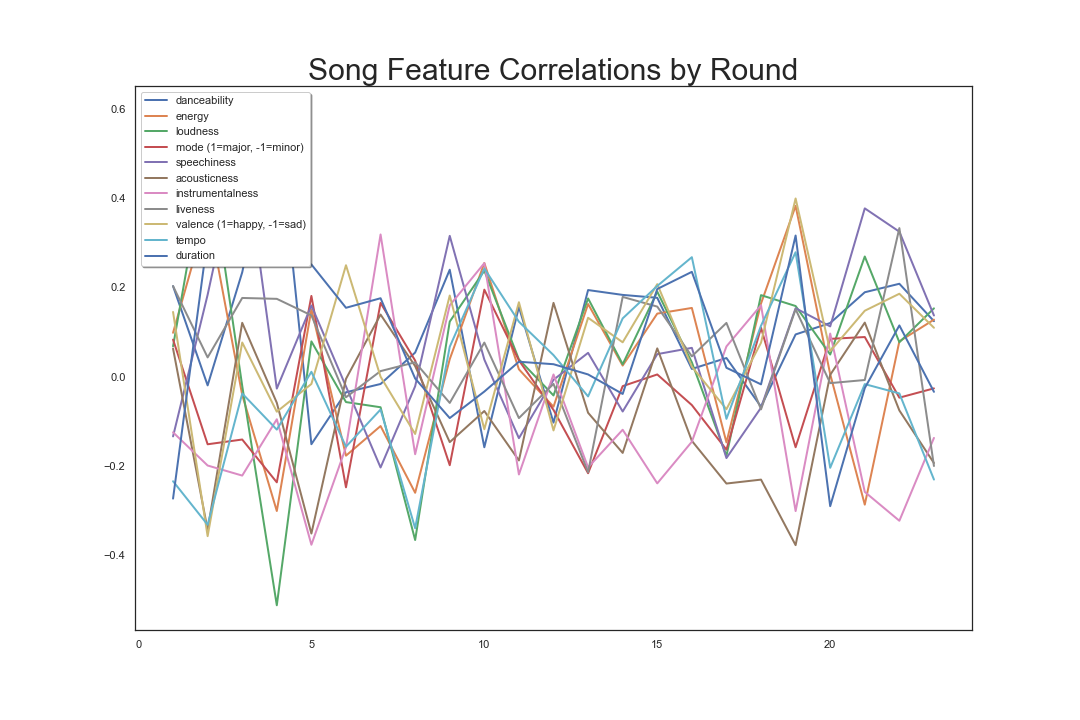

9

In [91]:
#graphing individual lines for each feature based on those arrays

fig, ax = plt.subplots()
ax.set_title('Song Feature Correlations by Round', size=60)
danceability_line, = ax.plot(t, danceability_corr_array, lw=2, label='danceability')
energy_line, = ax.plot(t, energy_corr_array, lw=2, label='energy')
loudness_line, = ax.plot(t, loudness_corr_array, lw=2, label='loudness')
mode_line, = ax.plot(t, mode_corr_array, lw=2, label='mode (1=major, -1=minor)')
speechiness_line, = ax.plot(t, speechiness_corr_array, lw=2, label='speechiness')
acousticness_line, = ax.plot(t, acousticness_corr_array, lw=2, label='acousticness')
instrumentalness_line, = ax.plot(t, instrumentalness_corr_array, lw=2, label='instrumentalness')
liveness_line, = ax.plot(t, liveness_corr_array, lw=2, label='liveness')
valence_line, = ax.plot(t, valence_corr_array, lw=2, label='valence (1=happy, -1=sad)')
tempo_line, = ax.plot(t, tempo_corr_array, lw=2, label='tempo')
duration_line, = ax.plot(t, duration_corr_array, lw=2, label='duration')

plt.legend(loc=2, prop={'size':20})

plt.title("Song Feature Correlations by Round", size=30)

leg = ax.legend(fancybox=True, shadow=True, loc=2)


#making the legend interactive
lines = [danceability_line, energy_line, loudness_line, mode_line, speechiness_line, acousticness_line,
        instrumentalness_line, liveness_line, valence_line, tempo_line, duration_line]
lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    lined[legline] = origline


def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

plt.gcf().set_size_inches(15, 10)
fig.canvas.mpl_connect('pick_event', on_pick)

## 3.1 Graphing personal correlations
### It turns out the above tells us absolutely nothing. Maybe personal-level feature stuff is interesting!

person_level_corr established earlier

In [33]:
person_level_corr = person_level_corr.reset_index()

In [34]:
del person_level_corr['level_1']

In [35]:
vote_and_submissions.head()

Spotify_URI                          Voter_ID  \
15362  spotify:track:3TATv4OQlg7WzRGqjwoY7q  be03c0bdbe8248699a4ba0a3797ae52f   
15460  spotify:track:0nys6GusuHnjSYLW0PYYb7  e2c317228ea34373a515e66d3a20c482   
15459  spotify:track:0mKGwFMHzTprtS2vpR3b6s  e2c317228ea34373a515e66d3a20c482   
15458  spotify:track:0IPKskRI33eRXjUhNUr9b5  e2c317228ea34373a515e66d3a20c482   
15457  spotify:track:7tmtdHPAoUZLuJqTnDR7FS  a61d5b98d58a4ddc93a720ef9f5cb865   

              Created_voter  Points_Assigned  \
15362  2022-09-09T09:33:28Z                4   
15460  2022-09-10T11:32:37Z                1   
15459  2022-09-10T11:32:37Z                1   
15458  2022-09-10T11:32:37Z                2   
15457  2022-09-10T02:20:18Z                3   

                              Comment_voter                          Round_ID  \
15362                                   NaN  09502eae8e58411fbe1f640e2d5d837b   
15460                                   NaN  09502eae8e58411fbe1f640e2d5d837b   
15459                                   NaN  09502eae8e58411fbe1f640e2d5d837b   
15458                          great opener  09502eae8e58411fbe1f640e2d5d837b   
15457  nice calming way to end the playlist  09502eae8e58411fbe1f640e2d5d837b   

                               ID_voter Name_voter  \
15362  be03c0bdbe8248699a4ba0a3797ae52f      Jared   
15460  e2c317228ea34373a515e66d3a20c482      y2ckt   
15459  e2c317228ea34373a515e66d3a20c482      y2ckt   
15458  e2c317228ea34373a515e66d3a20c482      y2ckt   
15457  a61d5b98d58a4ddc93a720ef9f5cb865     Zach V   

                           Submitter_ID     Created_submitter  \
15362  00ccf61afac848a5ba4d304c525fc34a  2022-09-04T23:41:05Z   
15460  b537dd84a6f646998366c28e4c1a16a0  2022-09-04T23:07:47Z   
15459  1ecb480139f24cc98c2ce6a2c2af9e4e  2022-09-05T20:32:26Z   
15458  7c97159365824bf4b0e2ccb6206c079b  2022-09-05T23:00:45Z   
15457  99d11bf38300420a95e28fc12a87c822  2022-09-04T23:12:38Z   

                                       Comment_submitter  \
15362  “idk if you guys have heard but lemon bowl lis...   
15460                                                NaN   
15459                                             i must   
15458                                                NaN   
15457  the original version is one of my favorites by...   

                           ID_submitter   Name_submitter  
15362  00ccf61afac848a5ba4d304c525fc34a       Lemon Bowl  
15460  b537dd84a6f646998366c28e4c1a16a0  tyler (she/her)  
15459  1ecb480139f24cc98c2ce6a2c2af9e4e          melissa  
15458  7c97159365824bf4b0e2ccb6206c079b           Hassan  
15457  99d11bf38300420a95e28fc12a87c822             Carl

In [36]:
mean_correlations = pd.merge(vote_and_submissions[['Spotify_URI','Name_voter','Points_Assigned']],song_feature_analysis,on='Spotify_URI')
del mean_correlations['Points_Assigned_y']
del mean_correlations['mode']
del mean_correlations['key']
del mean_correlations['time_signature']
del mean_correlations['Spotify_URI']
del mean_correlations['Name_voter']
del mean_correlations['Round_ID']
mean_correlations = mean_correlations.corr()

### Note for me - I think I shuold convert the "find personal features" bit into another function since i'll use that to predict the songs you'll like later

In [37]:
%matplotlib inline

In [38]:
def print_radargraph(name):
    #first, get the subset to reference
    all_matches = person_level_corr[person_level_corr['Name_voter'].str.contains(name)]
    testradar = all_matches.iloc[0,2:12]
    meanradar = mean_correlations.iloc[0,1:]
    
    #then, set up the chart
    categories = ['danceability','energy','loudness',
                  'speechiness', 'acousticness',
                  'instrumentalness', 'liveness',
                  'valence','tempo','duration']
    categories2 = [*categories, categories[0]]

    personal_features = testradar
    personal_features = [*personal_features, personal_features[0]]

    mean_features = meanradar
    mean_features = [*mean_features, mean_features[0]]
    
    #get to graphing!
    fig = go.Figure(
        data=[
            go.Scatterpolar(r=mean_features, theta=categories2, fill='toself', name='Group Correlations'),
            go.Scatterpolar(r=personal_features, theta=categories2, fill='toself', name='Your Correlations'),

        ],
        layout=go.Layout(
            title=go.layout.Title(text='Personal Feature Chart'),
            polar={'radialaxis': {'visible': True}},
            showlegend=True
            )
    )
    fig.update_polars(radialaxis=dict(range=[-.15, .15]))
    fig.show()

# 4. You can use this to find your personal feature correlations
### Just put in a part of your name that doesn't include spaces, exactly as it appears on music league.
#### No spaces! 
#### Caps-sensitive!
#### I'll include a full list.

In [39]:
competitors['Name']

0          Jack Fleming
1        Quinn (He/Him)
2                 y2ckt
3               hammond
4         Fondueprocess
5               Heather
6                Oliver
7               Allison
8                Will D
9                 scott
10          Aidanread27
11            Brendon Y
12    Mr. Peanut Butter
13                Ninon
14          chayamichla
15                   JR
16         Gideon Jones
17               em.………
18       Erin (she/her)
19                 IAAP
20               Zach V
21                 Zach
22               Sandra
23            Jonathan 
24                Ethan
25                  Dan
26                 meg 
27             nr031197
28              melissa
29      tyler (she/her)
30                Joe E
31            Klayton A
32          Gooth Ghoul
33           Lemon Bowl
34        joshuahwatson
35                Rob K
36              joshb42
37                 Dana
38                 Nate
39                 seth
40                Jared
41              

In [40]:
print_radargraph('Jack')

# 5. Heatmaps for Voting Habits
## Here, I pull together the data for heatmapping on voting habits. 

In [41]:
points_for = points_for.reset_index()

In [42]:
#clean up votes_for and votes_cast before merging into votes_for
votes_cast.rename(columns={'Points_Assigned': 'total_points_cast'}, inplace=True)
votes_cast = votes_cast.reset_index()
votes_for = votes_for.reset_index()

votes_for.rename(columns={'Points_Assigned': 'num_times_voted'}, inplace=True)

In [43]:
#reducing the votes_for and points_for tables into voter,submitter, and the relevant counts
del votes_for['Spotify_URI']
del votes_for['Created_voter']
del votes_for['Comment_voter']
del votes_for['Round_ID']
del votes_for['Created_submitter']
del votes_for['Comment_submitter']
del votes_for['ID_voter']
del votes_for['ID_submitter']
del votes_for['Voter_ID']
del votes_for['Submitter_ID']

votes_for.head()

Name_voter Name_submitter  num_times_voted
0  Aidanread27        Allison               14
1  Aidanread27         Angela               10
2  Aidanread27      Brendon Y               11
3  Aidanread27           Carl               12
4  Aidanread27            Dan               12

In [44]:
#combine the votes_cast table with points_for
points_for = points_for.merge(votes_cast, how='left', on=['Name_voter'])

In [45]:
avg_vote = votes_for.merge(points_for[['Name_voter', 'Name_submitter', 'Points_Assigned']], how='left', on=['Name_voter', 'Name_submitter'])
avg_vote["per_instance_avg"]=(avg_vote["Points_Assigned"]/avg_vote["num_times_voted"])
avg_vote = avg_vote.round({'per_instance_avg': 1})

In [46]:
#sns.scatterplot(x=points_for['Name_voter'],y=points_for['Name_submitter'],size=points_for['Points_Assigned'], sizes=(0,2500))
#plt.gcf().set_size_inches(32, 32)

In [47]:
#once they're merged, figure out what vote share goes to each other person
points_for["percent_share"]=(points_for["Points_Assigned"]/points_for["total_points_cast"])*100
percent_votes=points_for

In [48]:
#replace NaN with 0
percent_votes.fillna(0)
votes_for.fillna(0)
points_for.fillna(0)
avg_vote.fillna(0)

Name_voter   Name_submitter  num_times_voted  Points_Assigned  \
0     Aidanread27          Allison               14               32   
1     Aidanread27           Angela               10               22   
2     Aidanread27        Brendon Y               11               23   
3     Aidanread27             Carl               12               23   
4     Aidanread27              Dan               12               27   
...           ...              ...              ...              ...   
2108        y2ckt             owat                1                2   
2109        y2ckt            scott               11               14   
2110        y2ckt             sean               11               20   
2111        y2ckt             seth                3                3   
2112        y2ckt  tyler (she/her)                9               11   

      per_instance_avg  
0                  2.3  
1                  2.2  
2                  2.1  
3                  1.9  
4                  2.2  
...                ...  
2108               2.0  
2109               1.3  
2110               1.8  
2111               1.0  
2112               1.2  

[2113 rows x 5 columns]

In [49]:
#doing the pivot tables
percent_votes_t = percent_votes.pivot(index='Name_voter', columns='Name_submitter', values='percent_share')
votes_for_t = votes_for.pivot(index='Name_voter', columns='Name_submitter', values='num_times_voted')
points_for_t = points_for.pivot(index='Name_voter', columns='Name_submitter', values='Points_Assigned')
avg_vote_t = avg_vote.pivot(index='Name_voter', columns='Name_submitter', values='per_instance_avg') 

In [50]:
#replace NaN with 0
percent_votes_t = percent_votes_t.fillna(0)
votes_for_t = votes_for_t.fillna(0)
points_for_t = points_for_t.fillna(0)
avg_vote_t = avg_vote_t.fillna(0)

In [51]:
%matplotlib inline

In [52]:
def print_heatmap(df, title):
    ax = sns.heatmap(df,xticklabels=True, yticklabels=True, annot=True, linewidths=.25, center=0, cmap="YlGnBu", cbar=False)
    plt.title(title)
    plt.gcf().set_size_inches(32, 32)

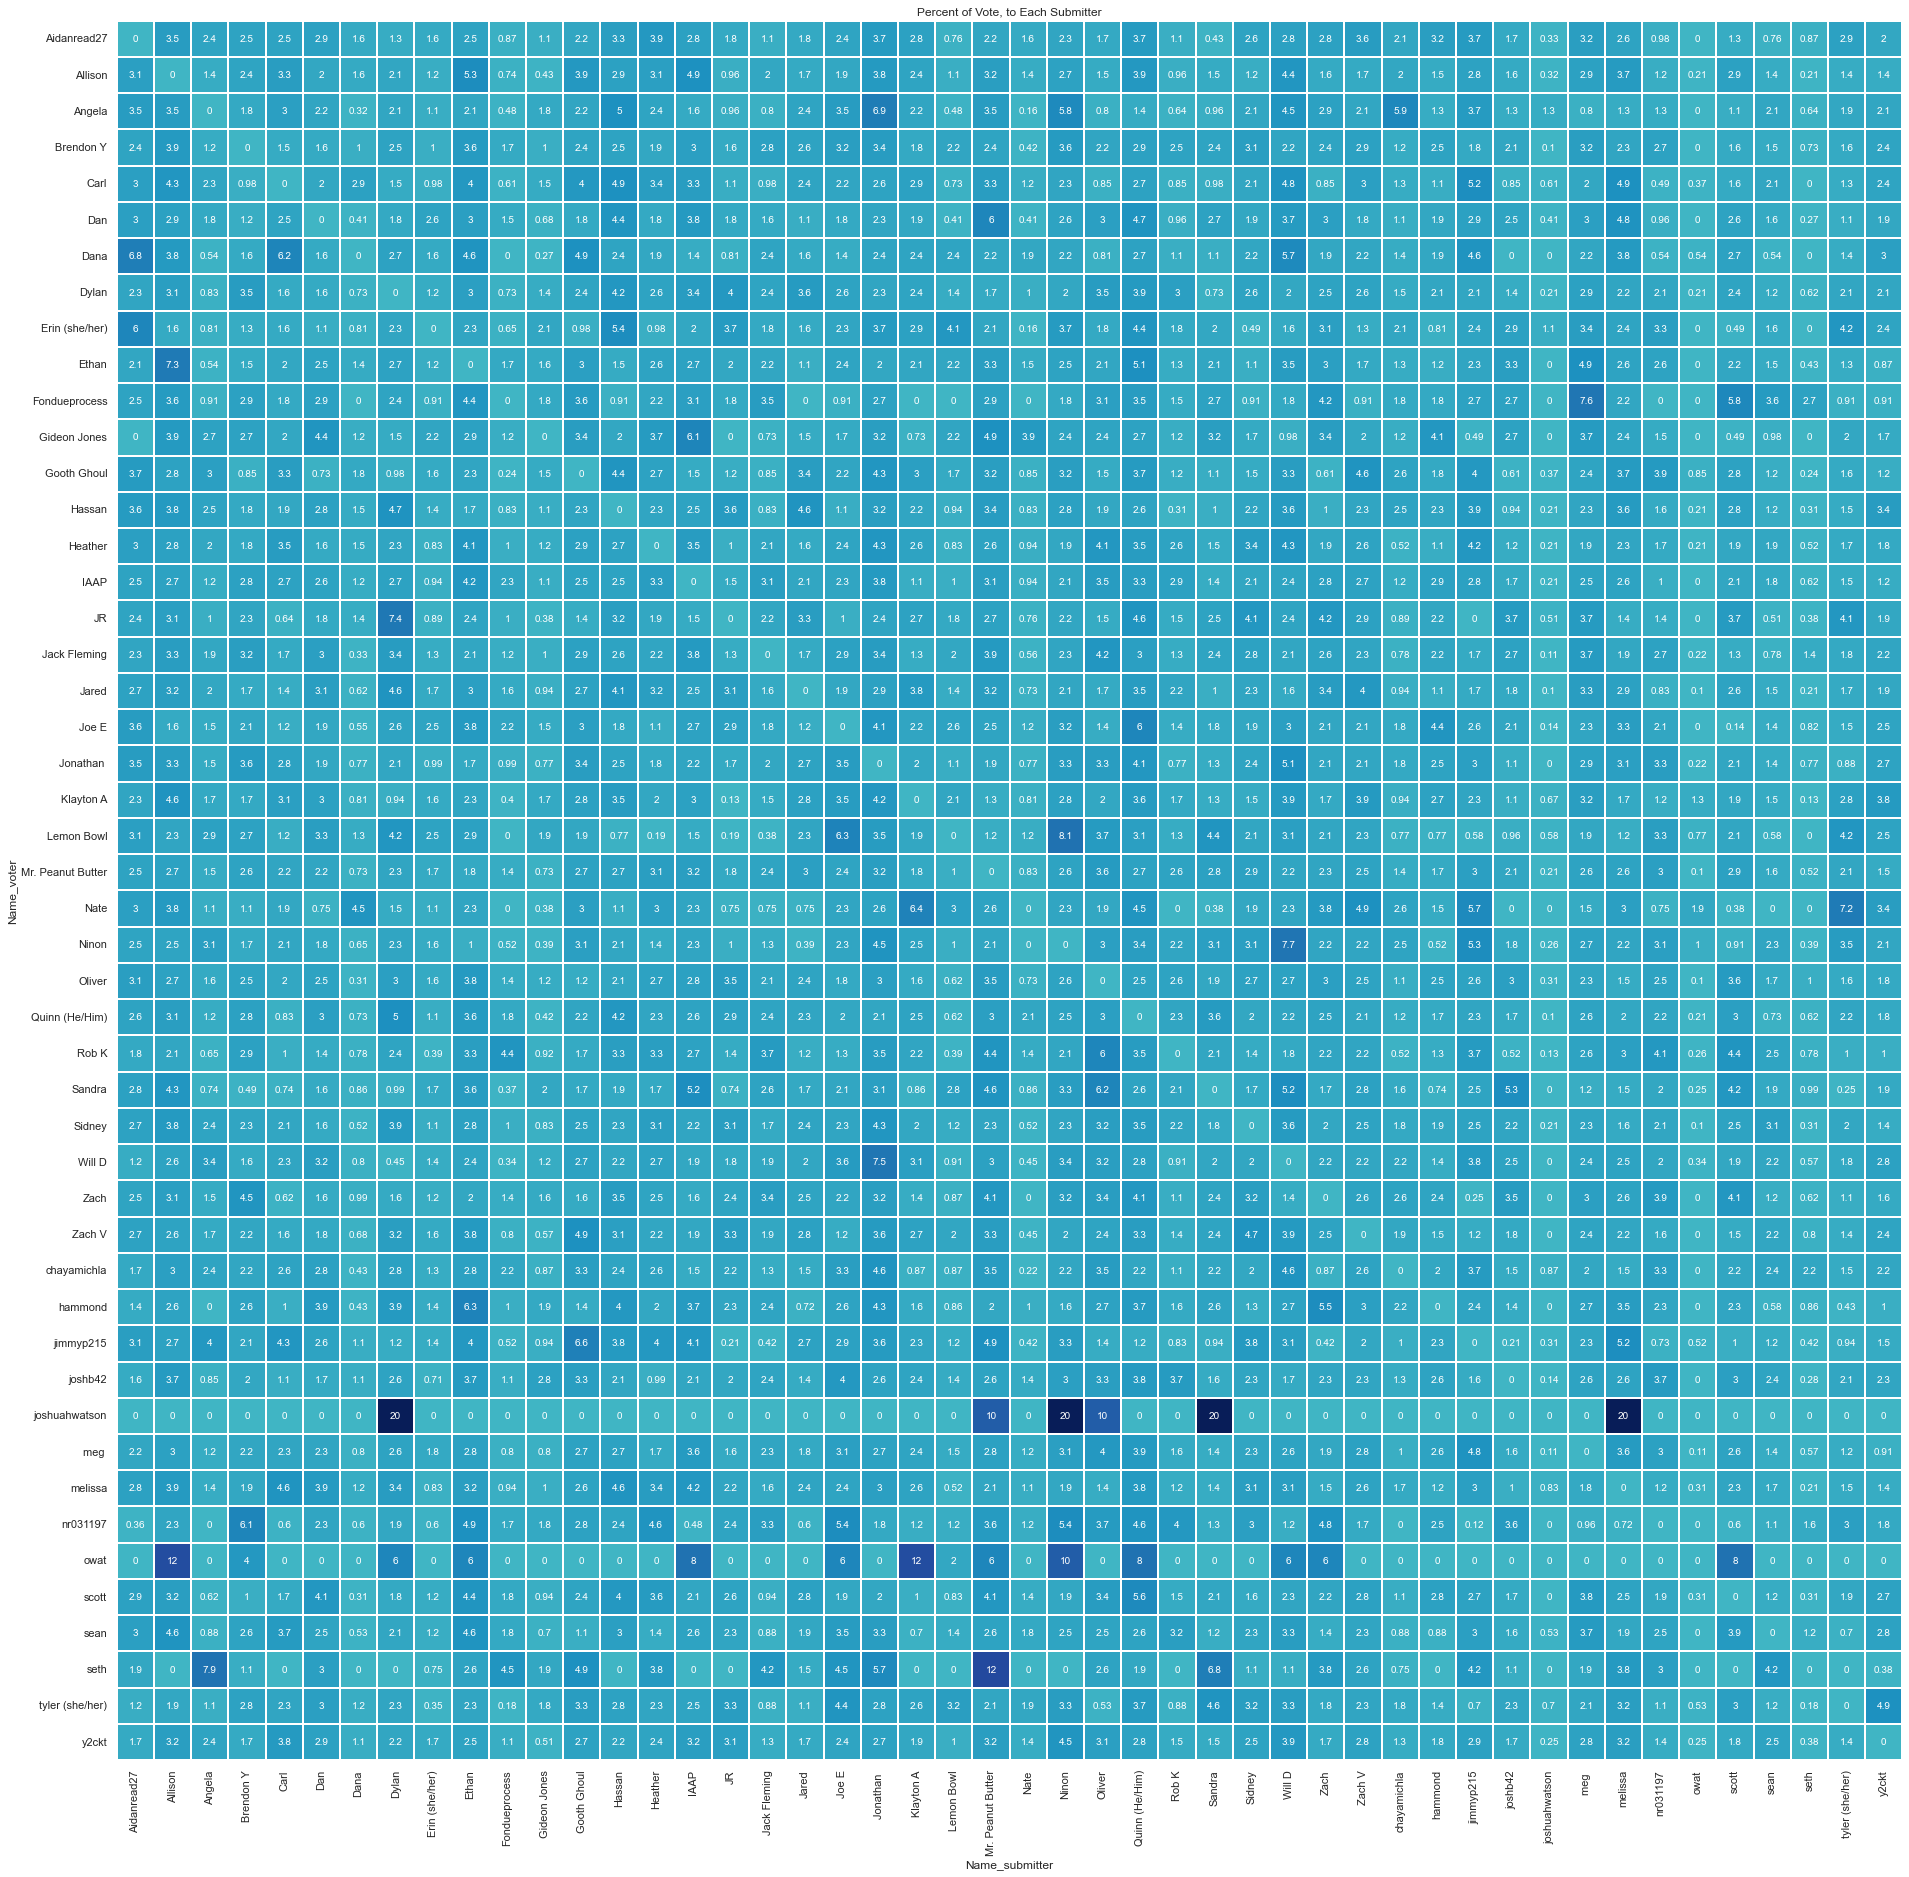

In [53]:
print_heatmap(percent_votes_t, "Percent of Vote, to Each Submitter")

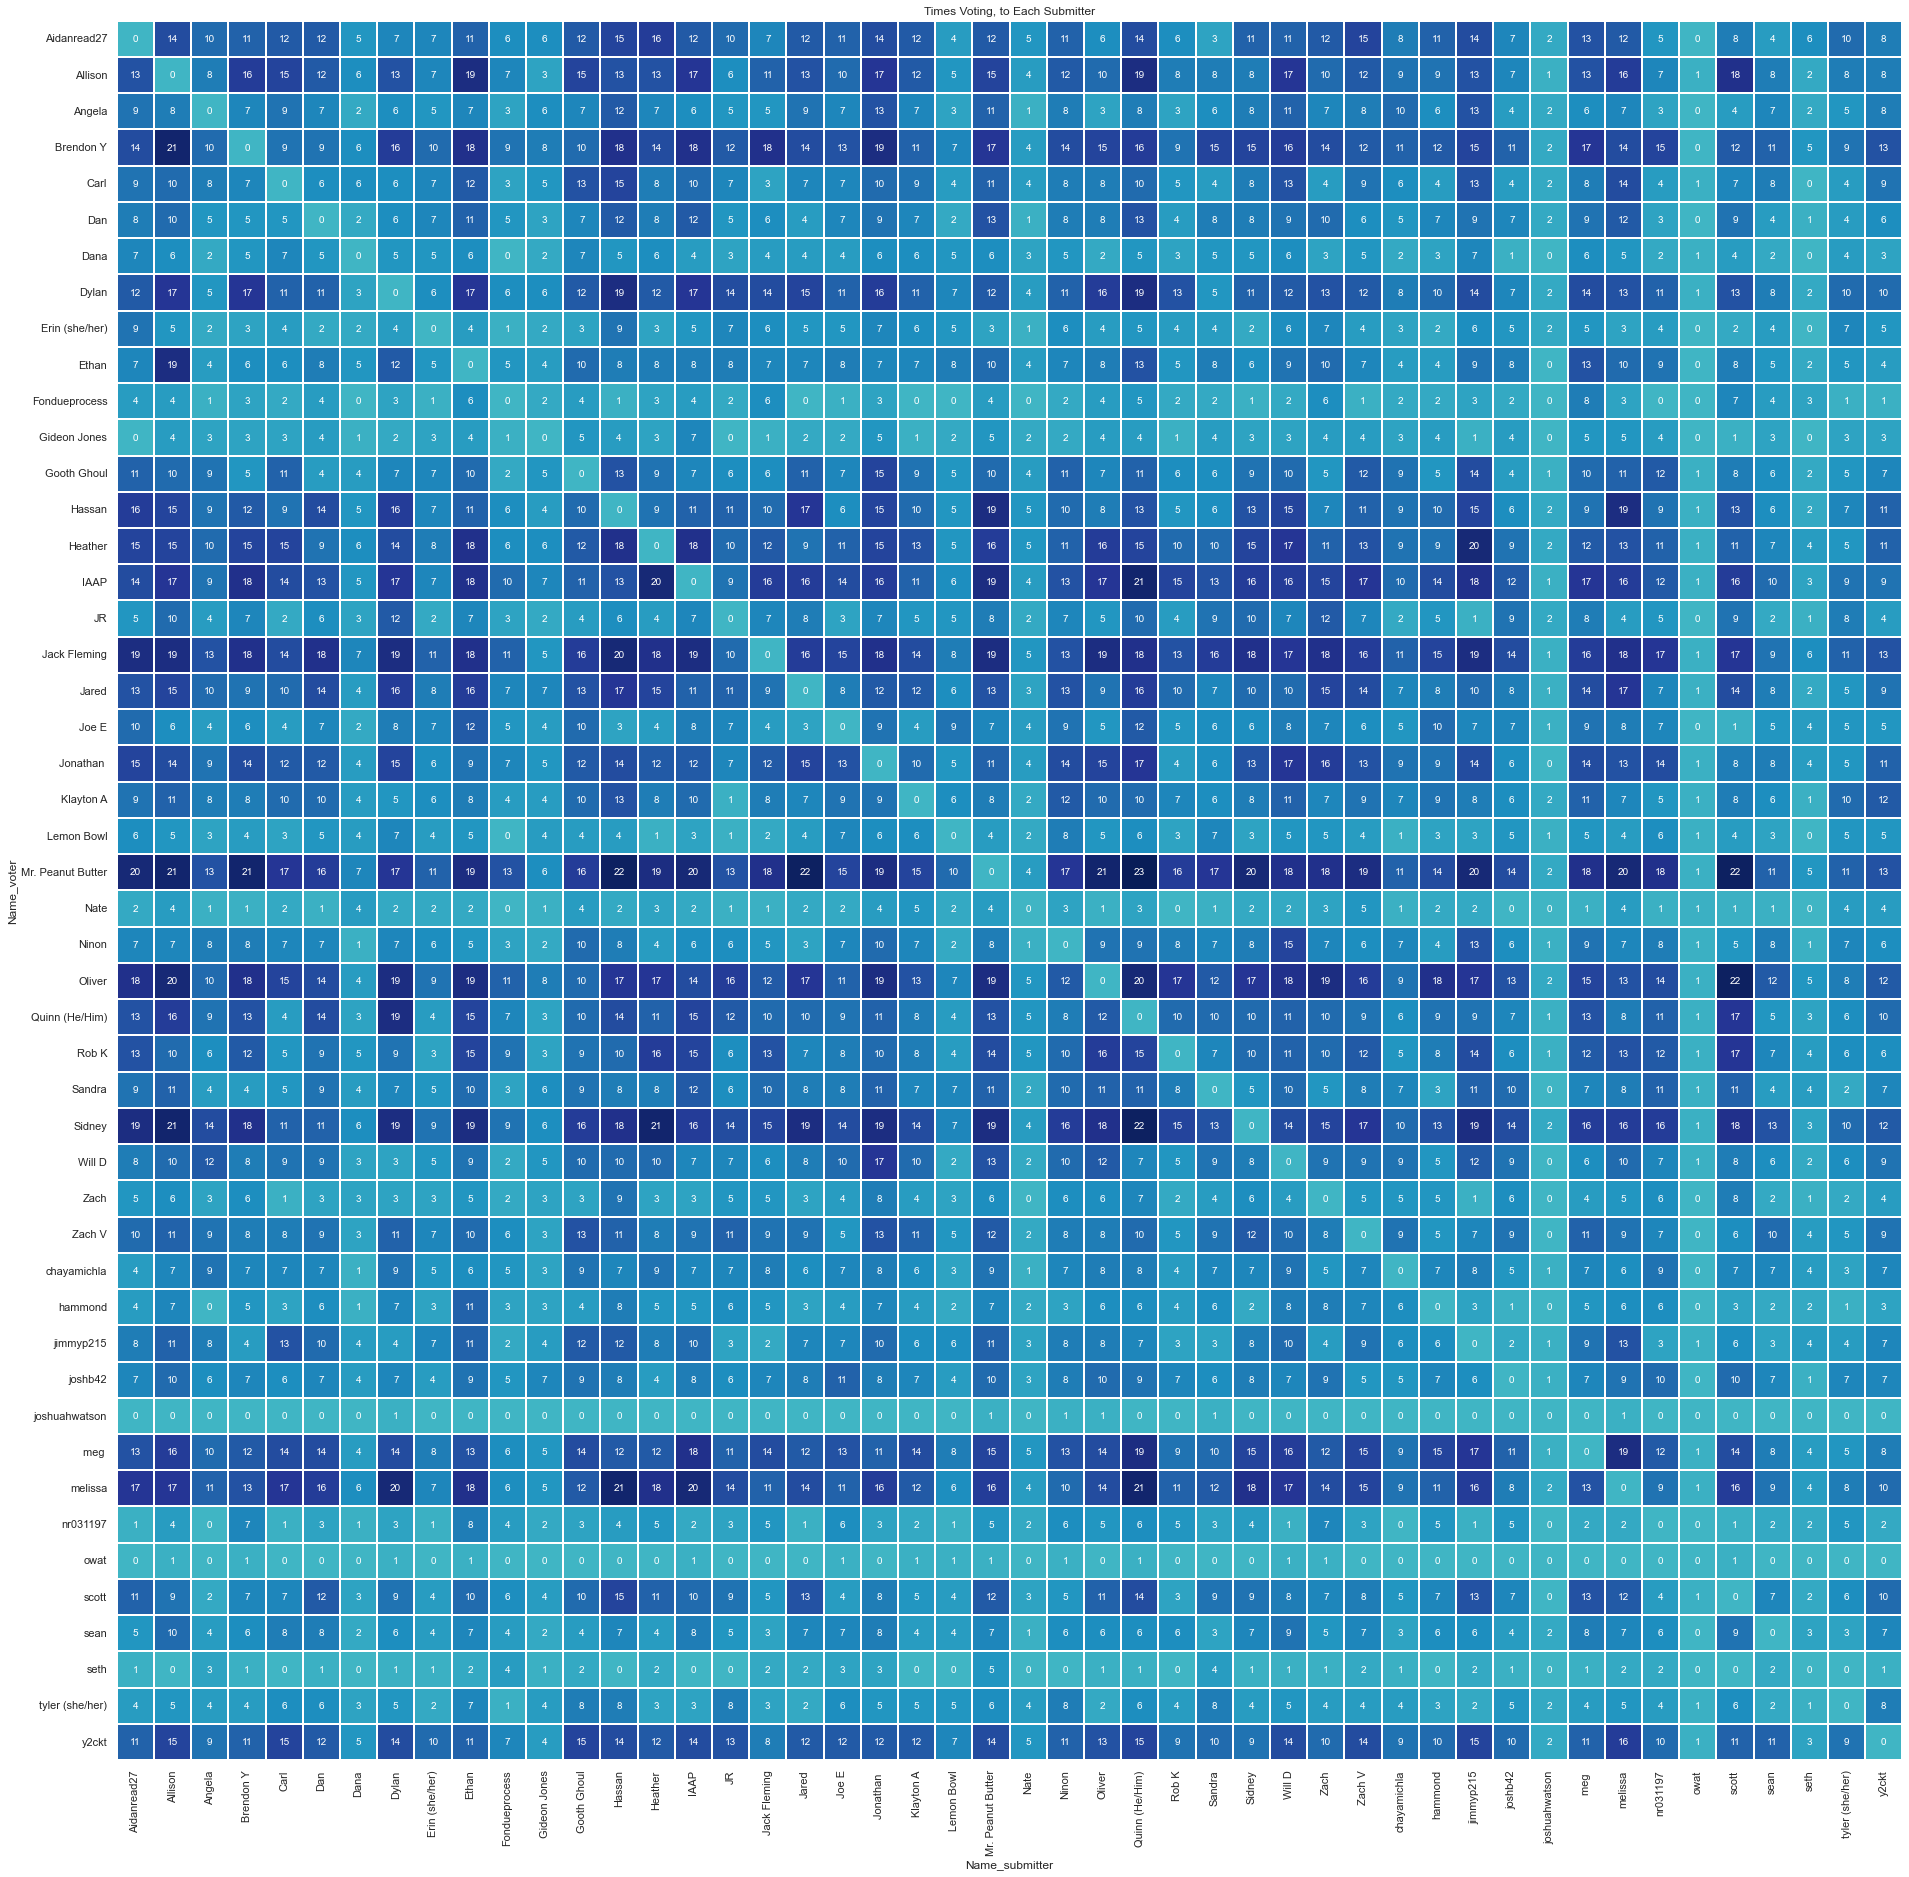

In [54]:
print_heatmap(votes_for_t, "Times Voting, to Each Submitter")

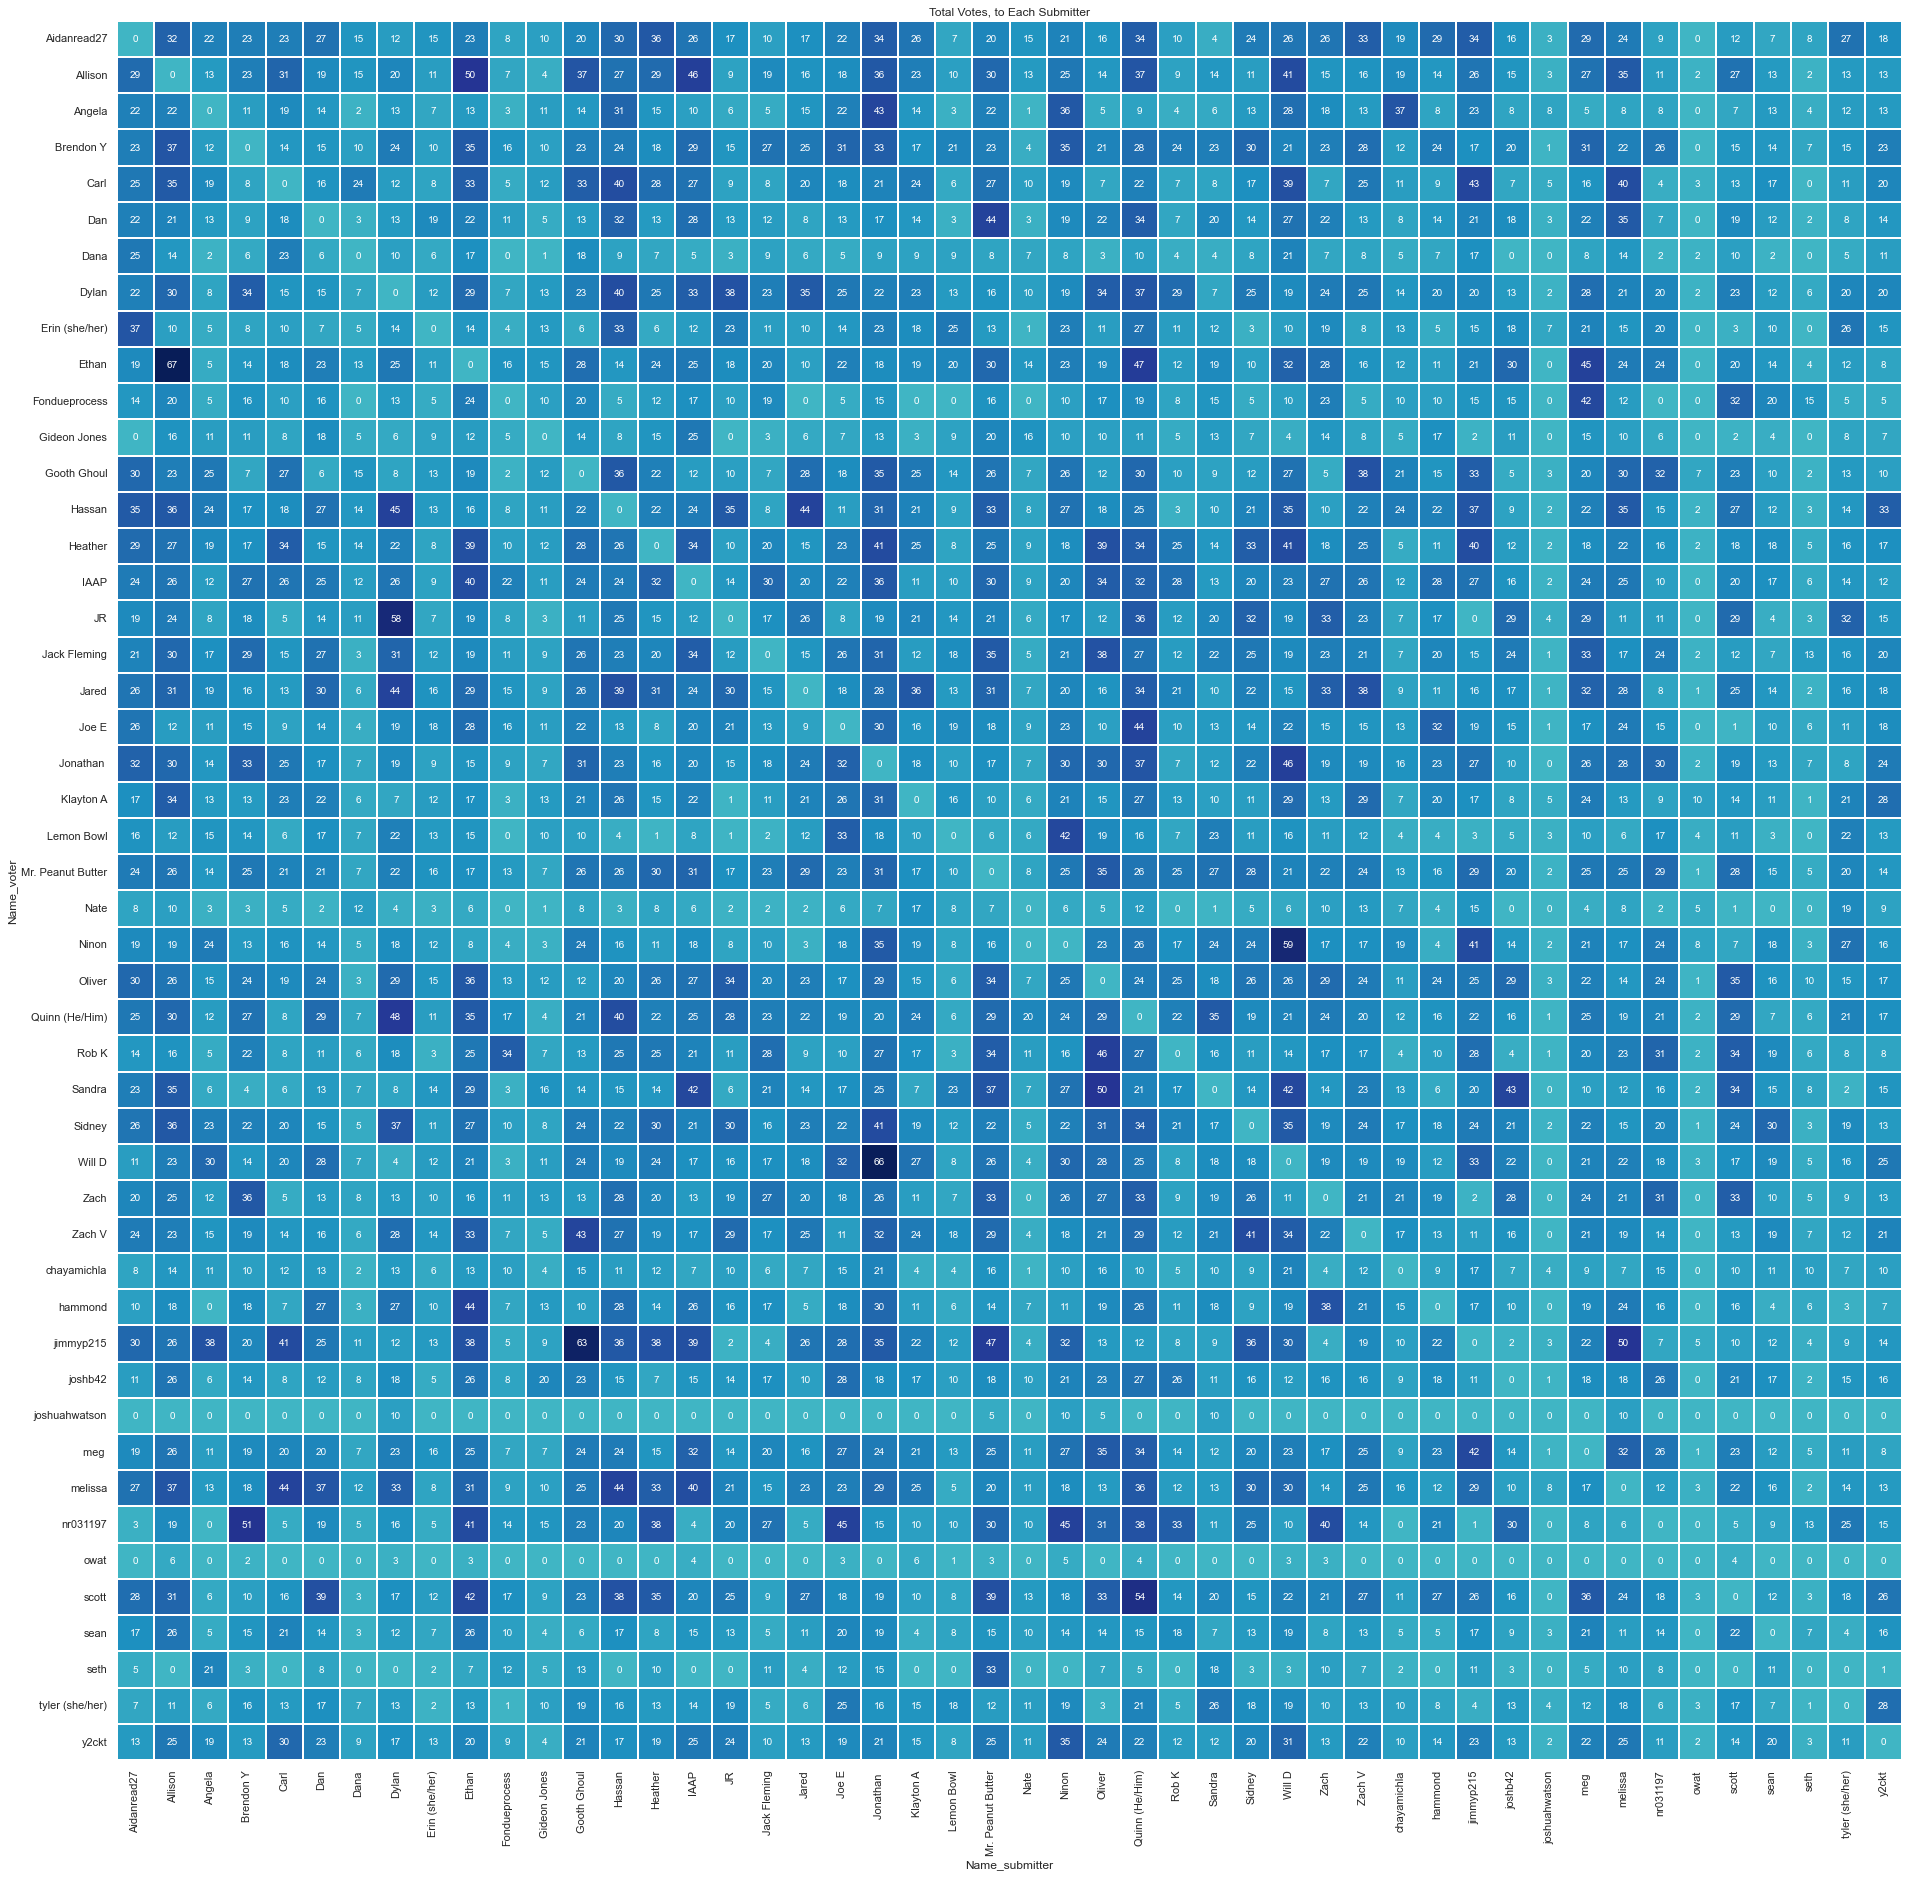

In [55]:
print_heatmap(points_for_t, "Total Votes, to Each Submitter")

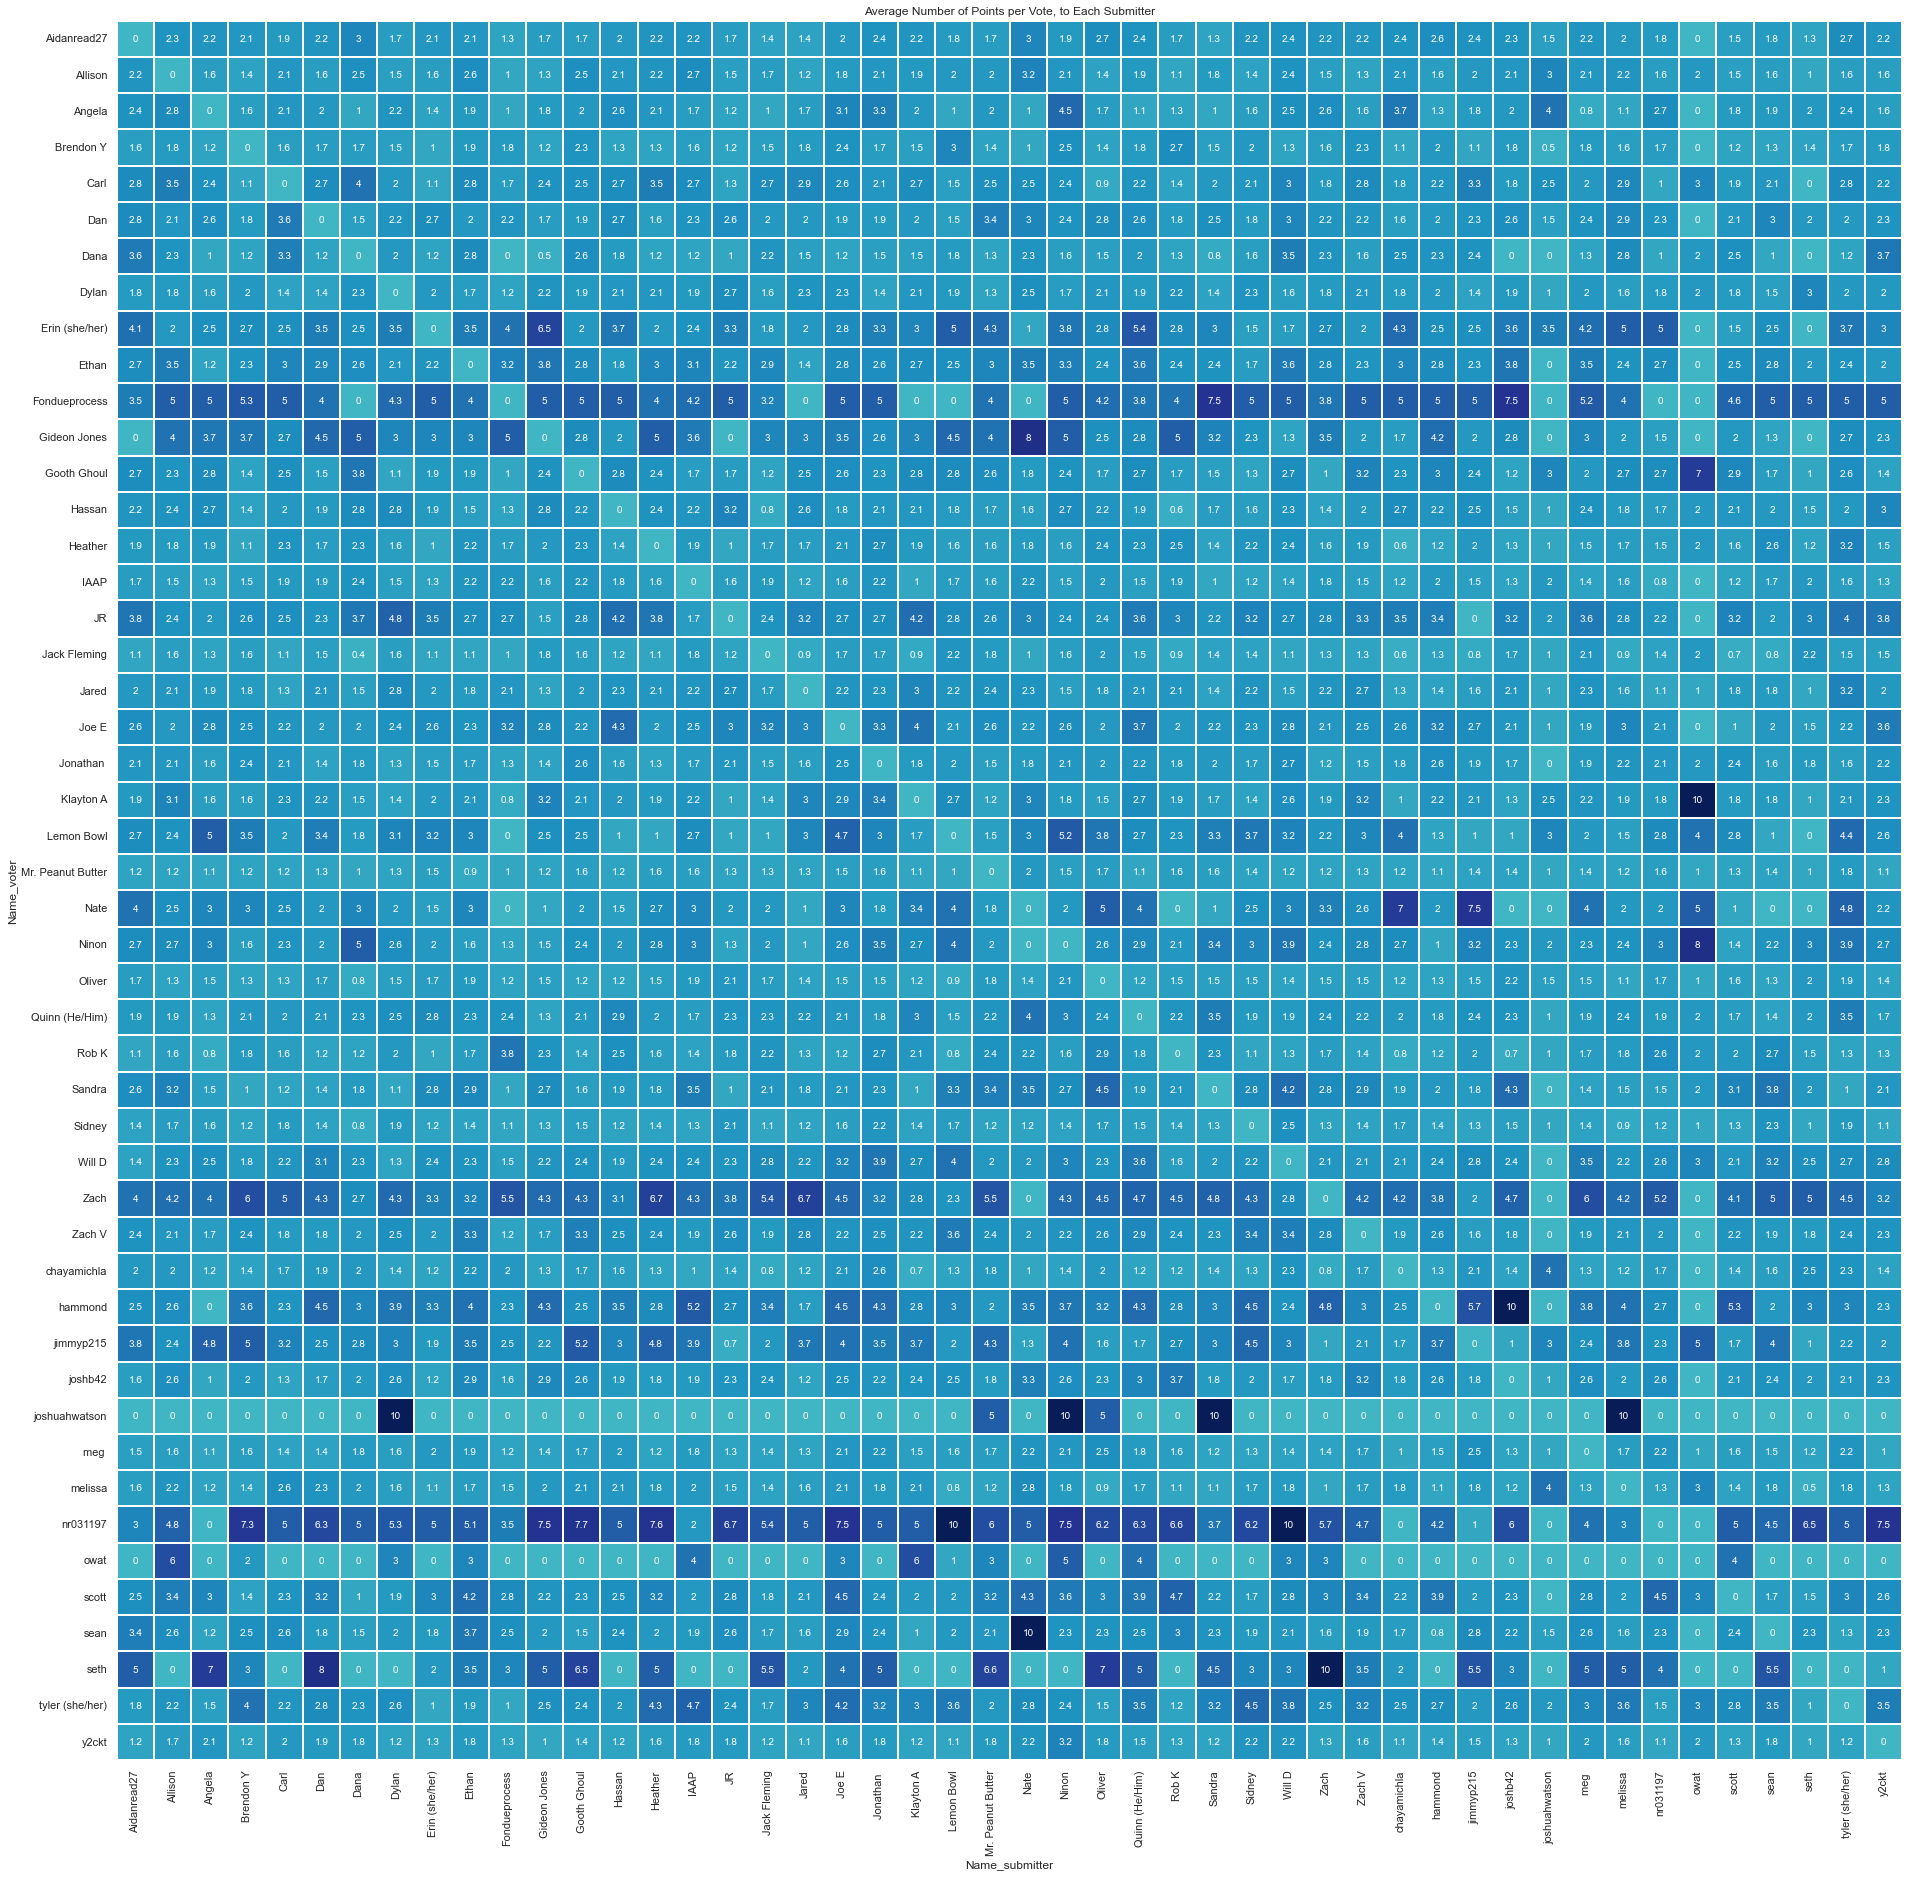

In [56]:
print_heatmap(avg_vote_t, "Average Number of Points per Vote, to Each Submitter")

In [57]:
#here, I create points_for_array and tranpose points_for_t so that the columns represent who the voter voted for
#that way, I can compare using .corr() from one column to the next 
points_for_array = points_for_t.transpose()
correlation_scores = points_for_array.corr()
correlation_scores = correlation_scores.round(2)
correlation_scores = correlation_scores.fillna(0)
correlation_scores.head()

Name_voter   Aidanread27  Allison  Angela  Brendon Y  Carl   Dan  Dana  Dylan  \
Name_voter                                                                      
Aidanread27         1.00     0.47    0.44       0.42  0.56  0.42  0.30   0.54   
Allison             0.47     1.00    0.41       0.40  0.60  0.62  0.62   0.39   
Angela              0.44     0.41    1.00       0.39  0.45  0.34  0.42   0.23   
Brendon Y           0.42     0.40    0.39       1.00  0.42  0.50  0.36   0.50   
Carl                0.56     0.60    0.45       0.42  1.00  0.56  0.54   0.38   

Name_voter   Erin (she/her)  Ethan  ...  joshuahwatson  meg   melissa  \
Name_voter                          ...                                 
Aidanread27            0.15   0.41  ...          -0.13  0.50     0.58   
Allison                0.29   0.22  ...           0.11  0.55     0.56   
Angela                 0.42   0.21  ...           0.09  0.37     0.51   
Brendon Y              0.43   0.50  ...           0.21  0.53     0.44   
Carl                   0.23   0.33  ...           0.07  0.53     0.50   

Name_voter   nr031197  owat  scott  sean  seth  tyler (she/her)  y2ckt  
Name_voter                                                              
Aidanread27      0.32  0.28   0.57  0.39  0.08             0.29   0.59  
Allison          0.17  0.31   0.47  0.45  0.21             0.40   0.59  
Angela           0.16  0.27   0.27  0.36  0.11             0.28   0.43  
Brendon Y        0.33  0.37   0.57  0.57  0.18             0.38   0.51  
Carl             0.01  0.29   0.50  0.36  0.21             0.31   0.50  

[5 rows x 48 columns]

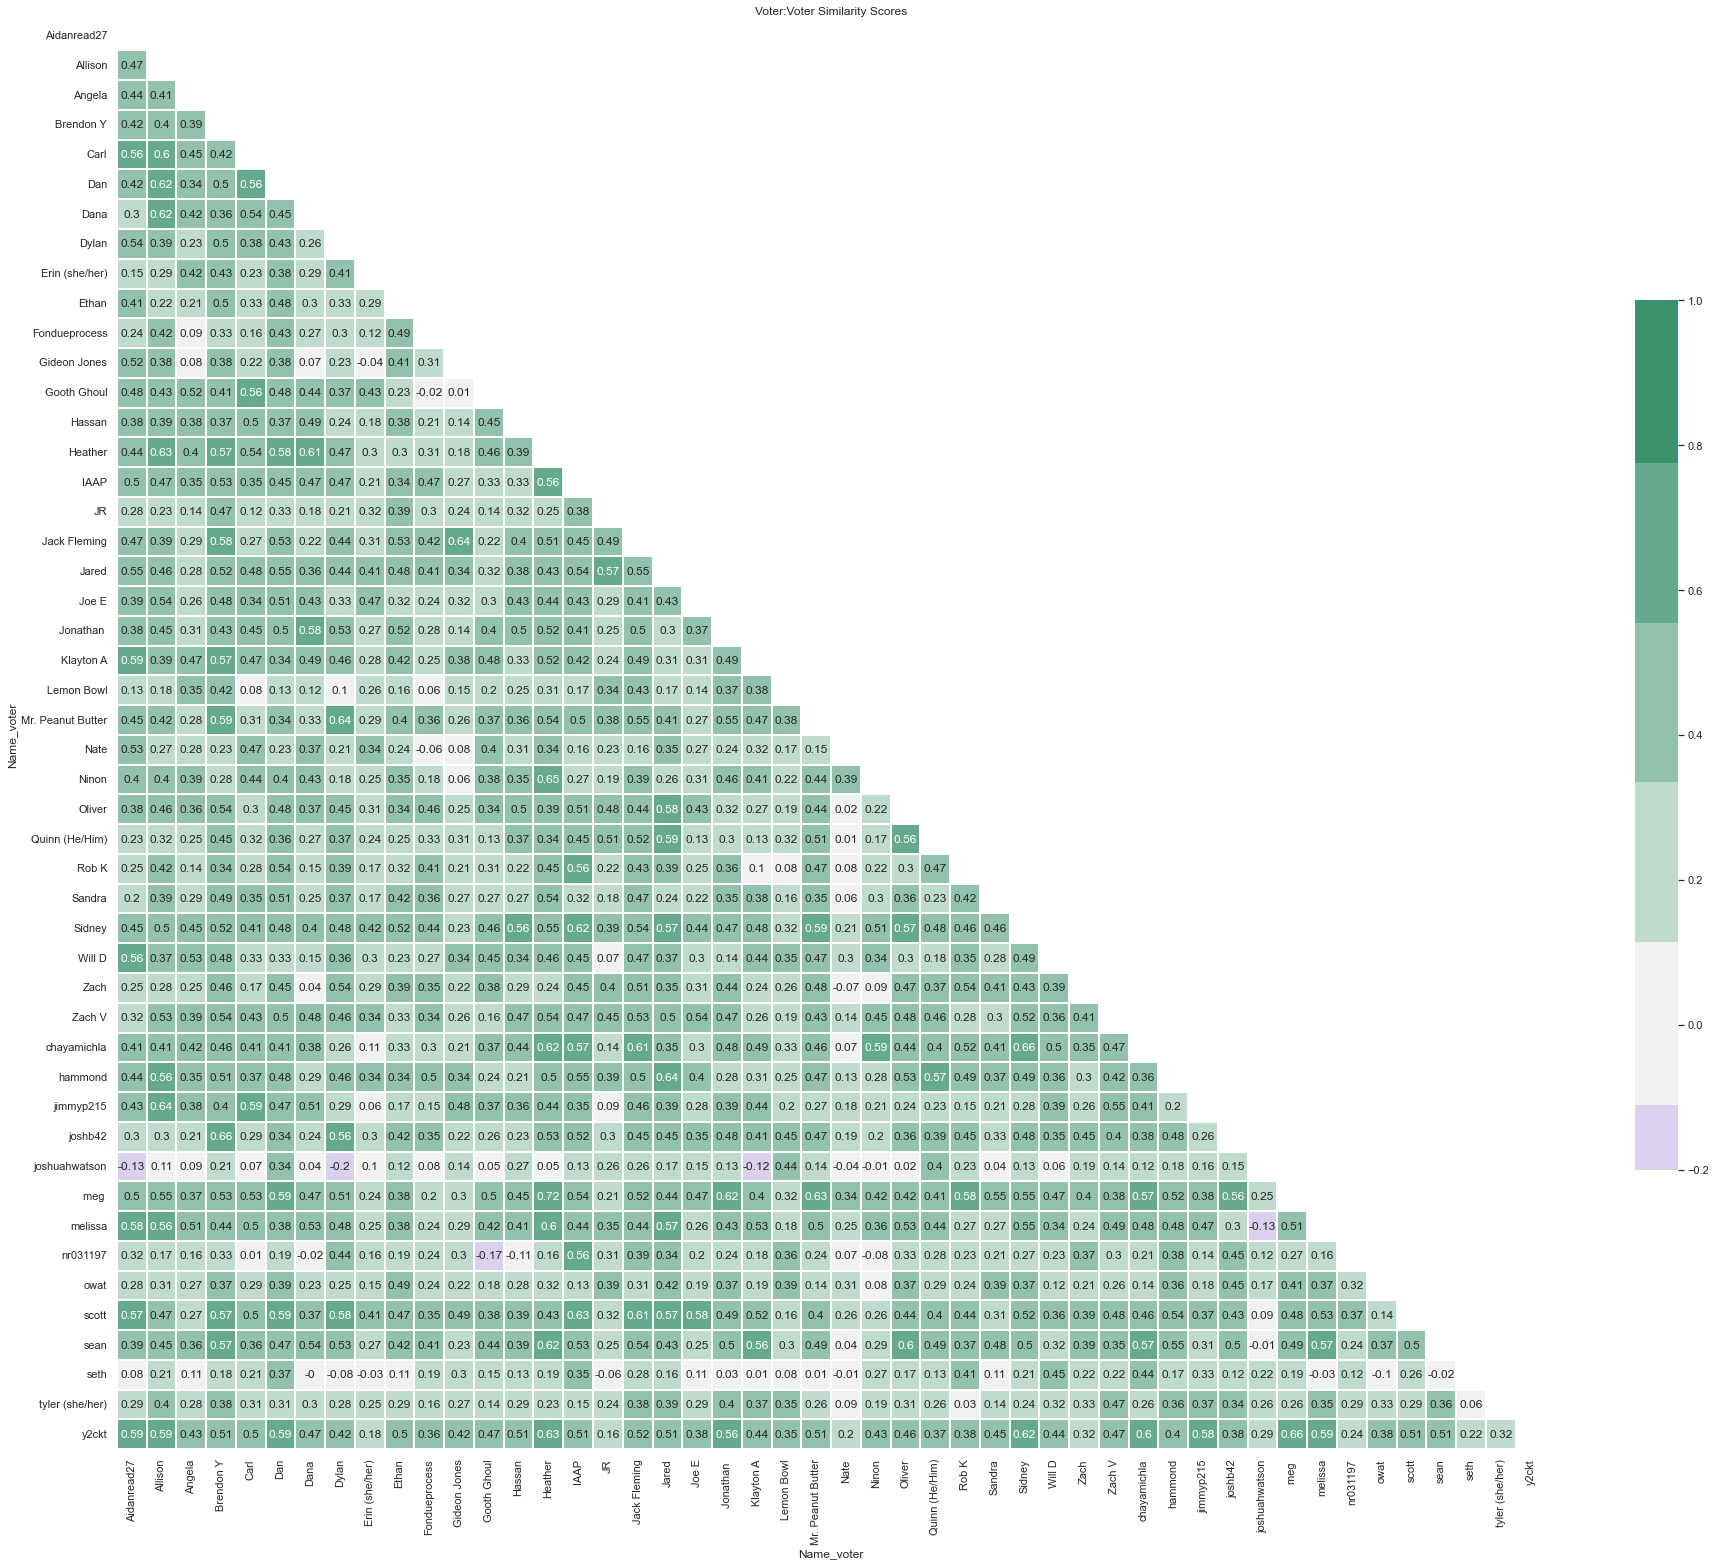

In [58]:
#heatmap for similarity in voting
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_scores, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(275, 150, s=80, l=55, n=9)


#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_scores, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-.2,
            square=True, linewidths=.25, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True, annot=True)

plt.title('Voter:Voter Similarity Scores')
plt.gcf().set_size_inches(32, 32)

In [59]:
#trying out cluster mapping
#sns.clustermap(correlation_scores,xticklabels=True, yticklabels=True, annot=True, linewidths=.25, center=0, cmap="YlGnBu", cbar=False)
#plt.title('clustermap')
#plt.gcf().set_size_inches(32, 32)

In [60]:
# % of your votes that went to the bottom 3 of each round
# % of your votes that went to the top 3 of each round
# to start out, need to figure out what's the order of songs in each round

round_song_sum = vote_and_submissions.groupby(['Round_ID', 'Name_submitter']).sum('Points_Assigned')
round_song_sum.rename(columns={'Points_Assigned': 'Points_Received'}, inplace=True)
e = round_song_sum.groupby('Round_ID').size()
num_per_round = pd.DataFrame(e)
num_per_round.rename(columns={0: 'count_songs'}, inplace=True)

# 6. Understanding Comments vs. Votes

In [61]:
#make a new df to capture competitor names, which we'll use to put round submission totals in
a=0
iter = len(competitors)
for a in range (a, iter):

    new_col = competitors.at[a,'Name']
    num_per_round[new_col]="0"
    num_per_round[new_col] = pd.to_numeric(num_per_round[new_col])

In [62]:
num_per_round = num_per_round.reset_index()

In [63]:
#here I might not need x?

a = 0
b = 0
c = 0
x=0
y=0

#apply this to each round in the round spreadsheet
for a in range (0,len(num_per_round)):
    
    current_round_ID = num_per_round.at[a,'Round_ID']
    
    #while focusing in on a round, check each participant
    for b in range (2,len(num_per_round.columns)):
        
        current_competitor_name = num_per_round.columns[b]

        #with those two variables, run through every row of the vote_and_submissions df
        for c in range (0,len(vote_and_submissions)):
       
            #maybe something here with like a while x < 1 that increments once it happens once
        
            #first, see if the row in v_a_s's round matches the current one
            if vote_and_submissions.at[c,'Round_ID'] == current_round_ID:
                
                #if so, check to see if the participant name is the same. if y add a point
                if vote_and_submissions.at[c,'Name_voter'] == current_competitor_name:
                
                    num_per_round.iat[a,b]+=1
                    
            else:

                y+=1


## 6.1 Looking at total songs each competitor saw 

In [64]:


competitor_total_engagements = pd.DataFrame()
competitor_total_engagements.loc(0)
#'Songs_voted_on', 'Num_rounds_in'

a=0
iter = len(competitors)
for a in range (a, iter):

    new_col = competitors.at[a,'Name']
    competitor_total_engagements[new_col]= ""
    competitor_total_engagements.at[0,new_col]= 0
    competitor_total_engagements[new_col] = pd.to_numeric(competitor_total_engagements[new_col])

In [65]:
#here i'll see the number of songs that each competitor interacted with. 

a = 0
b = 0
c = 0
x = 0
y = 0

#apply this to each round in the round spreadsheet
for a in range (2,len(num_per_round.columns)):
    
    round_competitor = num_per_round.columns[a]
    
    #while focusing in on a round, check each participant
    for b in range (0,len(competitor_total_engagements.columns)):

        check_competitor = competitor_total_engagements.columns[b]
        
        #if the two columns match...
        if round_competitor == check_competitor:

            #run a for loop within the num_per_round sheet to get all the rows where their engagement !=0
            for c in range (0,len(num_per_round)):
                                
                    if num_per_round.iat[c,a] > 0:
                        
                        #assign a variable to the number in the round's total cells
                        x = num_per_round.iat[c,1]
                        
                        #add that to a variable for this person's total engaged
                        competitor_total_engagements.iat[0,b] = competitor_total_engagements.iat[0,b]+x

In [66]:
competitor_total_engagements.head()

Jack Fleming  Quinn (He/Him)  y2ckt  hammond  Fondueprocess  Heather  \
0           768             818    648      601            499      818   

   Oliver  Allison  Will D  scott  ...  seth  Jared  Dylan  Hassan  sean  \
0     818      802     741    818  ...   242    818    818     818   487   

   Carl  Angela  jimmyp215  owat  Sidney  
0   684     542        818    40     818  

[1 rows x 49 columns]

In [67]:
#Start investigation of comments/voting breakdown
#list of competitors

competitor_engagement = competitors
competitor_engagement['vocal_advocate']=0 
competitor_engagement['silent_majority']=0
competitor_engagement['outspoken_critic']=0
competitor_engagement['silent_but_deadly']=0
vote_and_submissions['Comment_voter'] = vote_and_submissions['Comment_voter'].fillna('null')

In [68]:
#assign total songs engaged with to the competitor_engagement silent_but_deadly

a=0
b=0
x=0

#run through all rows in competitor engagement
for a in range (0,len(competitor_engagement)):
    
    #while focusing in on a participant, look through all votes ever cast
    for b in range (0,len(competitor_total_engagements.columns)): 
        
        if competitor_engagement.iat[a,1] == competitor_total_engagements.columns[b]:
            
            x = competitor_total_engagements.iat[0,b]
            competitor_engagement.iat[a,5] = x
            
#competitor_engagement['total_votes'] = competitor_engagement['silent_but_deadly']

In [69]:
startTime = time.time()

#run through every competitor in the league
#because the vote_and_submissions sheet doesn't capture non-engagements, 
#any time one of the other ones hits, i'll do a +1 and a -1 to the silent_but_deadly

a=0
b=0

for a in range (0,len(competitor_engagement)):
    
    #while focusing in on a participant, look through all votes ever cast
    for b in range (0,len(vote_and_submissions)):
       
        #when participant name and voter name match, check out details
        if competitor_engagement.at[a,'Name'] == vote_and_submissions.at[b,'Name_voter']:
            
            #first, separate whether or not points were cast
            if vote_and_submissions.at[b,'Points_Assigned'] == 0:
                
                #no points cast, comments added
                if vote_and_submissions.at[b,'Comment_voter'] != "null":
                    competitor_engagement.at[a,'outspoken_critic']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1
            
            #isolate times that points were cast
            elif vote_and_submissions.at[b,'Points_Assigned'] !=0: 
                
                #points cast, no comments added
                if vote_and_submissions.at[b,'Comment_voter'] == "null":
                    competitor_engagement.at[a,'silent_majority']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1

                #points cast, comments added
                if vote_and_submissions.at[b,'Comment_voter'] != "null":
                    competitor_engagement.at[a,'vocal_advocate']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1
          
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 6.754179239273071


In [70]:
#saving a lil copy just in case
competitor_engagement_backup = competitor_engagement

In [71]:
#converting the counts into percentages for better graphing
cols = ['vocal_advocate', 'silent_majority', 'outspoken_critic', 'silent_but_deadly']
competitor_engagement[cols] = competitor_engagement[cols].div(competitor_engagement[cols].sum(axis=1), axis=0).multiply(100)

In [72]:
#sorting the columns by vocal_advocacy
competitor_engagement = competitor_engagement.sort_values('vocal_advocate')
competitor_engagement.head()

ID           Name  vocal_advocate  \
34  b289f6bd176a46e688e791937178a1c7  joshuahwatson        0.000000   
47  baa33e187fbc43b98463c10a6e72e50c           owat        0.000000   
36  50bcd53a0bf84421a05d12190c08c895        joshb42        0.173611   
4   ac8a680b7955442a80c999deb6aab714  Fondueprocess        0.200401   
30  fe88b3f0df524756b638fe8ea42499e8          Joe E        0.978793   

    silent_majority  outspoken_critic  silent_but_deadly  
34        13.333333               0.0          86.666667  
47        35.000000               0.0          65.000000  
36        55.208333               0.0          44.618056  
4         23.847695               0.0          75.951904  
30        45.676998               0.0          53.344209

## 6.2 Graphing the four Comment/Votes relationships as a bar-chart

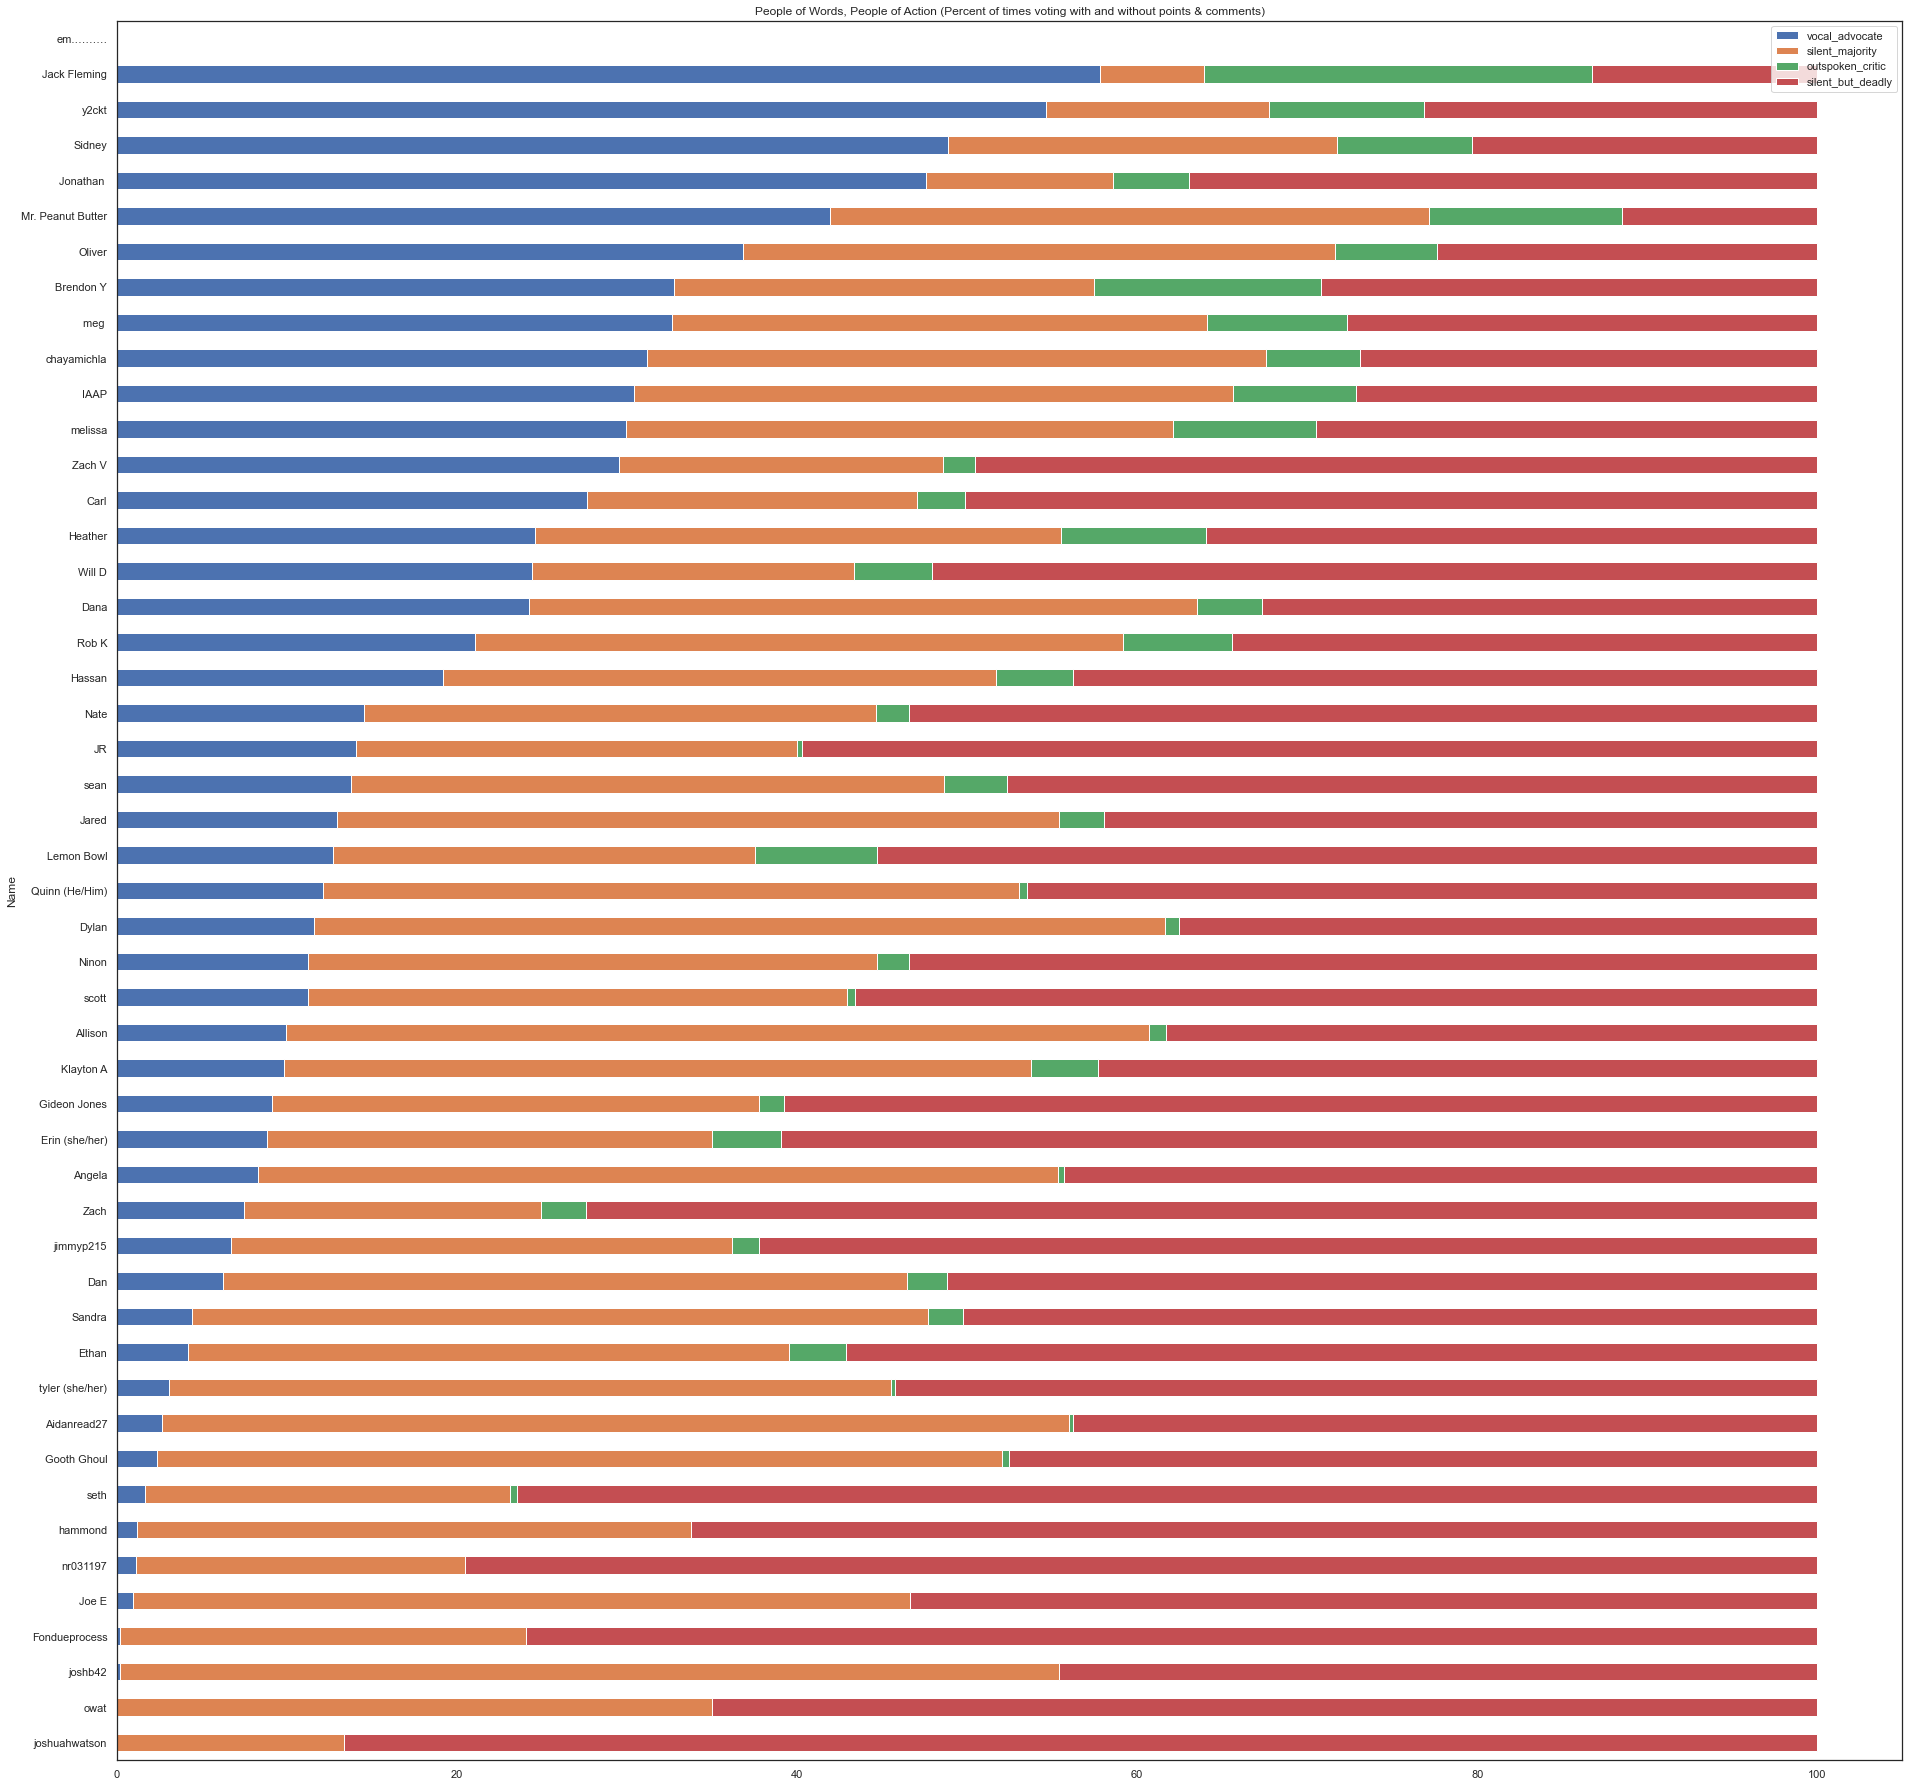

In [73]:
ax = competitor_engagement.plot.barh(x='Name', y=cols, stacked=True)

plt.title('People of Words, People of Action (Percent of times voting with and without points & comments)')
plt.gcf().set_size_inches(32, 32)

In [74]:
#maybe something here around % with points, and % with comments
#then do a quick clustering based on those two attributes to find voters with like behaviors, 
#absent their actual voting interests
percent_votes_comments = competitor_engagement
percent_votes_comments['Percent_positive']=percent_votes_comments['silent_majority']+percent_votes_comments['vocal_advocate']
percent_votes_comments['Percent_comments']=percent_votes_comments['outspoken_critic']+percent_votes_comments['vocal_advocate']

del percent_votes_comments['vocal_advocate']
del percent_votes_comments['silent_majority']
del percent_votes_comments['outspoken_critic']
del percent_votes_comments['silent_but_deadly']

percent_votes_comments.head()

ID           Name  Percent_positive  \
34  b289f6bd176a46e688e791937178a1c7  joshuahwatson         13.333333   
47  baa33e187fbc43b98463c10a6e72e50c           owat         35.000000   
36  50bcd53a0bf84421a05d12190c08c895        joshb42         55.381944   
4   ac8a680b7955442a80c999deb6aab714  Fondueprocess         24.048096   
30  fe88b3f0df524756b638fe8ea42499e8          Joe E         46.655791   

    Percent_comments  
34          0.000000  
47          0.000000  
36          0.173611  
4           0.200401  
30          0.978793

In [75]:
percent_votes_comments = percent_votes_comments.head(percent_votes_comments.shape[0] -1)

In [76]:
percent_votes_comments = percent_votes_comments.fillna(0)
percent_votes_comments = percent_votes_comments.astype({"Percent_positive":'int', "Percent_comments":'int'}) 

In [77]:
each_participants_points = points_for.groupby(['Name_submitter']).sum()
each_participants_points.rename(columns = {'Name_submitter':'Name'}, inplace = True)
each_participants_points.reset_index()
each_participants_points.head()

Points_Assigned  total_points_cast  percent_share
Name_submitter                                                   
Aidanread27                 915              34390     118.903937
Allison                    1123              34565     154.190181
Angela                      587              33570      78.411943
Brendon Y                   787              34810     103.921802
Carl                        749              34635      96.456951

# 7. Turning comments/votes into Scatterplot  

In [78]:
scatterplot_dataframe1 = pd.merge(percent_votes_comments, each_participants_points[['Points_Assigned']], left_on ='Name', right_on='Name_submitter')

In [79]:
scatterplot_dataframe1.head()

ID           Name  Percent_positive  \
0  b289f6bd176a46e688e791937178a1c7  joshuahwatson                13   
1  baa33e187fbc43b98463c10a6e72e50c           owat                35   
2  50bcd53a0bf84421a05d12190c08c895        joshb42                55   
3  ac8a680b7955442a80c999deb6aab714  Fondueprocess                24   
4  fe88b3f0df524756b638fe8ea42499e8          Joe E                46   

   Percent_comments  Points_Assigned  
0                 0               93  
1                 0               81  
2                 0              661  
3                 0              410  
4                 0              893

In [80]:
#vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).count()
rounds_participated = submissions.groupby(['Name']).count()
rounds_participated.rename(columns={'Spotify URI': 'Num_rounds'}, inplace=True)
del rounds_participated['Submitter ID']
del rounds_participated['Created']
del rounds_participated['Comment']
del rounds_participated['Round ID']
del rounds_participated['ID']

scatterplot_dataframe1 = scatterplot_dataframe1.merge(rounds_participated[['Num_rounds']], on ='Name')
scatterplot_dataframe1['avg_per_round']=scatterplot_dataframe1['Points_Assigned']/scatterplot_dataframe1['Num_rounds']
scatterplot_dataframe1.head()

ID           Name  Percent_positive  \
0  b289f6bd176a46e688e791937178a1c7  joshuahwatson                13   
1  baa33e187fbc43b98463c10a6e72e50c           owat                35   
2  50bcd53a0bf84421a05d12190c08c895        joshb42                55   
3  ac8a680b7955442a80c999deb6aab714  Fondueprocess                24   
4  fe88b3f0df524756b638fe8ea42499e8          Joe E                46   

   Percent_comments  Points_Assigned  Num_rounds  avg_per_round  
0                 0               93           2      46.500000  
1                 0               81           1      81.000000  
2                 0              661          14      47.214286  
3                 0              410          14      29.285714  
4                 0              893          16      55.812500

In [81]:
positive_mean = scatterplot_dataframe1['Percent_positive'].mean()
comments_mean = scatterplot_dataframe1['Percent_comments'].mean()

## 7.1 Creating kmeans clusters on habits 

In [82]:
# K-Means clustering to find 2 clusters based on comments and votes
kmeans = KMeans(n_clusters=4, random_state=0).fit(scatterplot_dataframe1[["Percent_positive", "Percent_comments"]])


# See the cluster label for each data point / Group label of each voter
kmean_labels = kmeans.labels_
kmeans.labels_



array([1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0], dtype=int32)

In [83]:
# Identifying the (final) cluster centroids
kmeans.cluster_centers_

array([[67.2       , 60.8       ],
       [30.38461538,  6.46153846],
       [58.41666667, 34.75      ],
       [50.66666667,  9.5       ]])

In [84]:
labels = scatterplot_dataframe1['Name'].to_numpy()
labels

array(['joshuahwatson', 'owat', 'joshb42', 'Fondueprocess', 'Joe E',
       'nr031197', 'hammond', 'seth', 'Gooth Ghoul', 'Aidanread27',
       'tyler (she/her)', 'Ethan', 'Sandra', 'Dan', 'jimmyp215', 'Zach',
       'Angela', 'Erin (she/her)', 'Gideon Jones', 'Klayton A', 'Allison',
       'scott', 'Ninon', 'Dylan', 'Quinn (He/Him)', 'Lemon Bowl', 'Jared',
       'sean', 'JR', 'Nate', 'Hassan', 'Rob K', 'Dana', 'Will D',
       'Heather', 'Carl', 'Zach V', 'melissa', 'IAAP', 'chayamichla',
       'meg ', 'Brendon Y', 'Oliver', 'Mr. Peanut Butter', 'Jonathan ',
       'Sidney', 'y2ckt', 'Jack Fleming'], dtype=object)

## 7.2 Graphing with cluster colors 

In [85]:
#%matplotlib inline
%matplotlib notebook

<IPython.core.display.Javascript object>


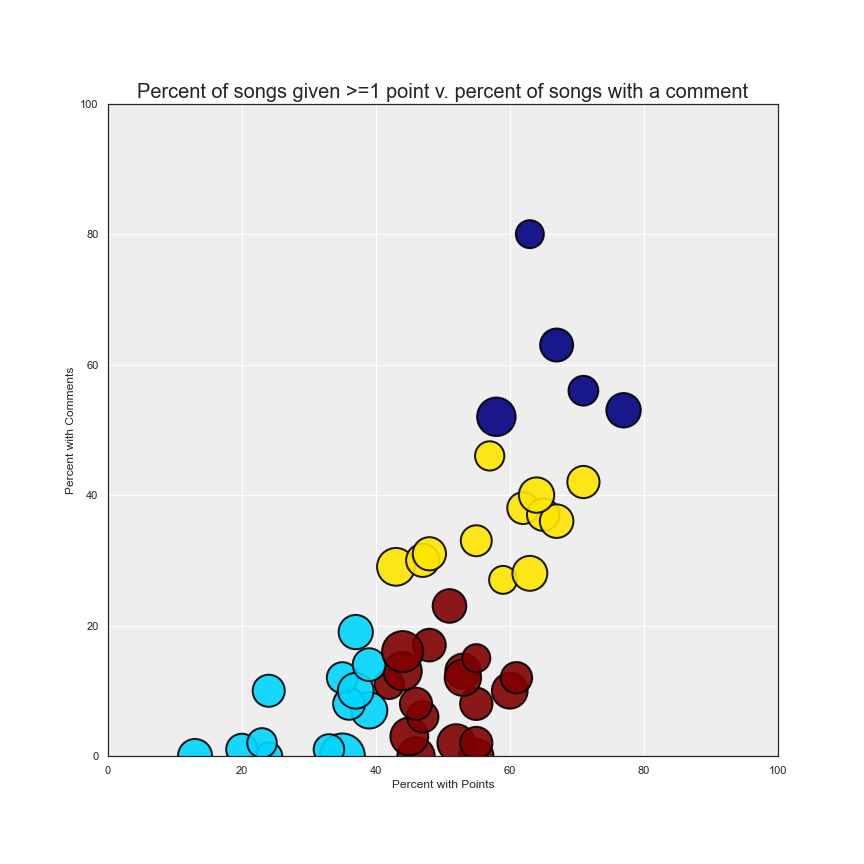

In [86]:

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))
N = len(competitors)-1

scatter = ax.scatter(x=scatterplot_dataframe1.Percent_positive,
                     y=scatterplot_dataframe1.Percent_comments,
                     s=25*scatterplot_dataframe1.avg_per_round,
                     c=kmean_labels,
                     alpha=0.9,
                     cmap=plt.cm.jet,
                     linewidths=2,
                     edgecolors='black')
ax.grid(color='white', linestyle='solid')

ax.set_title("Percent of songs given >=1 point v. percent of songs with a comment", size=20)

mplcursors.cursor().connect(
    "add", lambda sel: sel.annotation.set_text(scatterplot_dataframe1["Name"][sel.index]))    

    
plt.gcf().set_size_inches(12, 12)
plt.xlabel('Percent with Points')
plt.ylabel('Percent with Comments')
plt.xlim([0, 100])
plt.ylim([0, 100])


plt.ion
plt.isinteractive = True
#mpld3.display()

# 8. Establishing Points-Above-Replacement-Submission

In [87]:
competitor_PARS = competitors
competitor_PARS.head()

ID            Name  vocal_advocate  \
0  f99a5821c49d4a8eaa40dbc457beda3c    Jack Fleming       57.812500   
1  e595e8971f0d4500b512f788f52e60da  Quinn (He/Him)       12.102689   
2  e2c317228ea34373a515e66d3a20c482           y2ckt       54.629630   
3  2a1b637e09834879baf13d6cc3459270         hammond        1.164725   
4  ac8a680b7955442a80c999deb6aab714   Fondueprocess        0.200401   

   silent_majority  outspoken_critic  silent_but_deadly  
0         6.119792         22.786458          13.281250  
1        40.953545          0.488998          46.454768  
2        13.117284          9.104938          23.148148  
3        32.612313          0.000000          66.222962  
4        23.847695          0.000000          75.951904

In [88]:
# points above replacement submission
    #PARS
    #Look at the median submission for each round
    #subtract that from your submission each round
    #sum per voter
    
#need to do both:
    #median submission per round
    #which competitor was in each round

In [89]:
round_song_sum = round_song_sum.merge(num_per_round, how='left', on=['Round_ID'])


round_song_sum.reset_index()

#num_per_round now shows the number of songs submitted in each round. 
#now, we merge that with round_song_sum so we can identify how many to .nlargest()


####n.largest()????

round_song_sum.head()

#here we gotta figure out how to essentially tag each song submitted with position in the submissions per that round

# then, see who what percent of each person's votes went to a top 3 song and a bottom 3 song 
# by incorporating the votes_and_submission table

#round_song_sum = round_song_sum.groupby(['Round_ID', 'Name_submitter']).nlargest()
#round_song_sum.head()

Round_ID  Points_Received  count_songs  \
0  09502eae8e58411fbe1f640e2d5d837b               32           40   
1  09502eae8e58411fbe1f640e2d5d837b               40           40   
2  09502eae8e58411fbe1f640e2d5d837b               31           40   
3  09502eae8e58411fbe1f640e2d5d837b               59           40   
4  09502eae8e58411fbe1f640e2d5d837b               20           40   

   Jack Fleming  Quinn (He/Him)  y2ckt  hammond  Fondueprocess  Heather  \
0            35              16     28       12              0       25   
1            35              16     28       12              0       25   
2            35              16     28       12              0       25   
3            35              16     28       12              0       25   
4            35              16     28       12              0       25   

   Oliver  ...  seth  Jared  Dylan  Hassan  sean  Carl  Angela  jimmyp215  \
0      28  ...     0     25     24      24     0    19       0         22   
1      28  ...     0     25     24      24     0    19       0         22   
2      28  ...     0     25     24      24     0    19       0         22   
3      28  ...     0     25     24      24     0    19       0         22   
4      28  ...     0     25     24      24     0    19       0         22   

   owat  Sidney  
0     0      38  
1     0      38  
2     0      38  
3     0      38  
4     0      38  

[5 rows x 52 columns]

In [90]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,matplotlib,seaborn,nltk,sklearn,mpld3,mplcursors,spotipy,plotly,watermark

print (" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

pandas    : 1.4.2
numpy     : 1.21.5
matplotlib: 3.5.1
seaborn   : 0.11.2
nltk      : 3.7
sklearn   : 1.0.2
mpld3     : 0.5.8
mplcursors: 0.5.1
spotipy   : 2.20.0
plotly    : 5.6.0
watermark : 2.3.1

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

 
Last updated: Tue Sep 20 2022 10:46:25EDT

